# **Проект: Обучение с учителем: качество модели**

***Цель проекта*** - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Руководство клиента одобрило описание решения, которое необходимо реализовать:

***1)*** Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

***2)*** В исследование включить данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

***3)*** Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**План работ:**

***1)*** Загрузить и изучить информацию из файлов 'market_file.csv', 'market_time.csv', 'market_money.csv' и 'money.csv', подготовить данные для последующего анализа.

***2)*** Провести необходимую предобработку данных:
- откорректировать названия столбцов;
- изменить формат данных при необходимости;
- избавиться от явных и неявных дубликатов.

***3)*** Провести исследовательский анализ данных:

- провести статистический анализ всех признаков, построить графики для каждого признака: гистограммы, диаграммы размаха для количественных и столбчатые диаграммы для категориальных.
- отобрать клиентов с покупательской активностью не менее трёх месяцев.

***4)*** Объединить таблицы market_file.csv, market_money.csv, market_time.csv.

***5)*** Провести корреляционный анализ данных:

- рассчитать коэффициенты корреляции между всеми признаками;
- построить матрицы корреляции Спирмана и Фи.
- выявить мультиколлинеарность между входными признаками;

***6)*** Построить и применить все изученные модели используя пайплайны:

- обработать количественные и категориальные признаки;
- обучить четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(), для каждой модели подобрать как минимум один гиперпараметр;
- выбрать подходящую для задачи метрику;
- выбервть лучшую модель, используя заданную метрику.

***7)*** Оценить важность признаков для лучшей модели и построить графики важности с помощью метода SHAP.

***8)*** Выполнить сегментацию покупателей используя результаты моделирования и данные о прибыльности покупателей.

- выбрать группу покупателей, провести аналитическое и графическое исследование этой группы;
- сделать предложения по работе с сегментом для увеличения покупательской активности.

## ***Шаг 1. Загрузка данных***

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install shap -q
!python -m venv sklearn-env
!sklearn-env\Scripts\activate  # activate
!pip install -U scikit-learn -q
!pip install -U imbalanced-learn -q

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import random
import seaborn as sns
import scipy.stats as st
import shap
RANDOM_STATE = 42
TEST_SIZE = 0.25


from phik import resources, report
from scipy.stats import spearmanr

from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (SelectKBest, f_classif, mutual_info_classif) 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
                             make_scorer, confusion_matrix,\
                             recall_score, precision_score,\
                             accuracy_score, f1_score,\
                             roc_auc_score 
                            )
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import (
                                    KFold, StratifiedKFold, cross_val_score,\
                                    GridSearchCV, RandomizedSearchCV,\
                                    train_test_split
                                    )
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
                                   StandardScaler, MinMaxScaler,\
                                   RobustScaler, OneHotEncoder,\
                                   OrdinalEncoder, LabelEncoder,\
                                   PolynomialFeatures
                                   )
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
                        


In [3]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', delimiter=",")
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', delimiter=",")
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', delimiter=",")
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', delimiter=";", decimal=",")

Ознакомимся с информацией в таблицах "market_file", 'market_money, 'market_time', 'money'.

In [4]:
display(market_file.head())
market_file.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
display(market_money.head())
market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
display(market_time.head())
market_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
display(money.head())
money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


***Выводы после ознакомления с данными:***

1) При чтении файлов 'market_file', 'market_money', 'market_time' использовали парамтеры delimiter =',', т к в исходных файлах в одном столбце находилось несколько значений, разделенных с помощью ','. В файле 'money' использовали параметр delimiter =';'.

2) При чтении файла 'money' использовали перметр decimal = ',', т к в исходных файлах в дробных числах стоял разделитель запятая ',', и его нужно было заменито на точку '.'.

3) Пропуски во всех таблицах отсутствуют: после ознакомления с таблицами с помощью info() видим, что все строки заполнены.

4) Глядя на количество строк в таблицах, можно сделать вывод, что в базе 1300 клиентов. Во второй таблице ("market_money") собрана информация за 3 периода по каждому клиенту (3900 строк), в  третьей таблице ("market_time") - за 2 периода (текущий и предыдущий месяц, 2600 строк).

## **Шаг 2. Предобработка данных**

***2.1 Приведем названия столбцов в таблицах к нижнему регистру.***

In [5]:
market_file.columns = (market_file.columns).str.lower()
display(market_file.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [6]:
market_money.columns = (market_money.columns).str.lower()
display(market_money.columns)

Index(['id', 'период', 'выручка'], dtype='object')

In [7]:
market_time.columns = (market_time.columns).str.lower()
display(market_time.columns)

Index(['id', 'период', 'минут'], dtype='object')

In [8]:
money.columns = (money.columns).str.lower()
display(money.columns)

Index(['id', 'прибыль'], dtype='object')

***2.2 Проверим файлы на наличие полных дубликатов.***

In [9]:
market_file.duplicated().sum()

0

In [10]:
market_money.duplicated().sum()

0

In [11]:
market_time.duplicated().sum()

0

In [12]:
money.duplicated().sum()

0

Проверка на полные дубликаты в данном случае, скорее, формальность, т к в случае, если все id  уникальны, информация в остальных столбцах может быть какой угодно. Имеет смысл проверить первый файл на наличие повторяющихся id, т к при одинаковых id  в разных строках нужно будет объединить эти строки в одну, т к это один и тот же клиент "разбился" по строкам.

In [13]:
market_file.loc[market_file.duplicated(['id'])]

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


Одинаковых id нет, идем дальше.

***2.3 Проверим типы данных в файлах.***

In [19]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Проверим неявные дубликаты в згначениях столбца "популярная_категория" таблицы market_file:

In [14]:
market_file['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

Проверим неявные дубликаты в значениях столбца "Тип сервиса" таблицы market_file:

In [15]:
market_file['тип сервиса'].value_counts()

тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Исправим опечатку в названии.

In [16]:
market_file = market_file.replace(['стандартт'], ['стандарт'])

In [17]:
market_file['тип сервиса'].value_counts()

тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

При первом выводе таблицы заметила некорректное написание названия периода в таблице 'market_time'. Посмотрим уникальные названия признаков.

In [18]:
market_time['период'].value_counts()

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

Исправим.

In [19]:
market_time = market_time.replace(['предыдцщий_месяц'], ['предыдущий_месяц'])
market_time['период'].value_counts()

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

***Выводы по предобработке данных:***

**1)** Привели названия столбцов к нижнему регистру.

**2)** Явных и неявных дубликатов, пропусков в файлах не обнаружено.

**3)** Типы данных в таблицах у всех признаков корректные.

**4)** Устранили опечатки в названии признака "Тип сервиса" и в названии периода в таблице market_time.

## **Шаг 3. Исследовательский анализ данных.**

Начнем с анализа количественных показателей в файле ferma_main. Построим гистограммы и диаграммы размаха для количественных показателей:
- Среднее число маректинговых коммуникаций с клиентом за 6 мес;
- Количество маркетинговых коммуникаций в текущем месяце;
- Длительность пребывания клиента на сайте с момента регистрации;
- Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
- Среднее число просмотренных категорий за визит;
- Общее число неоплаченных товаров в корзине за последние 3 месяца;
- Число сбоев, которые коснулись покупателя во время посещения сайта;
- Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Смотрим графики для показателя "Среднее число маректинговых коммуникаций с клиентом за 6 мес".

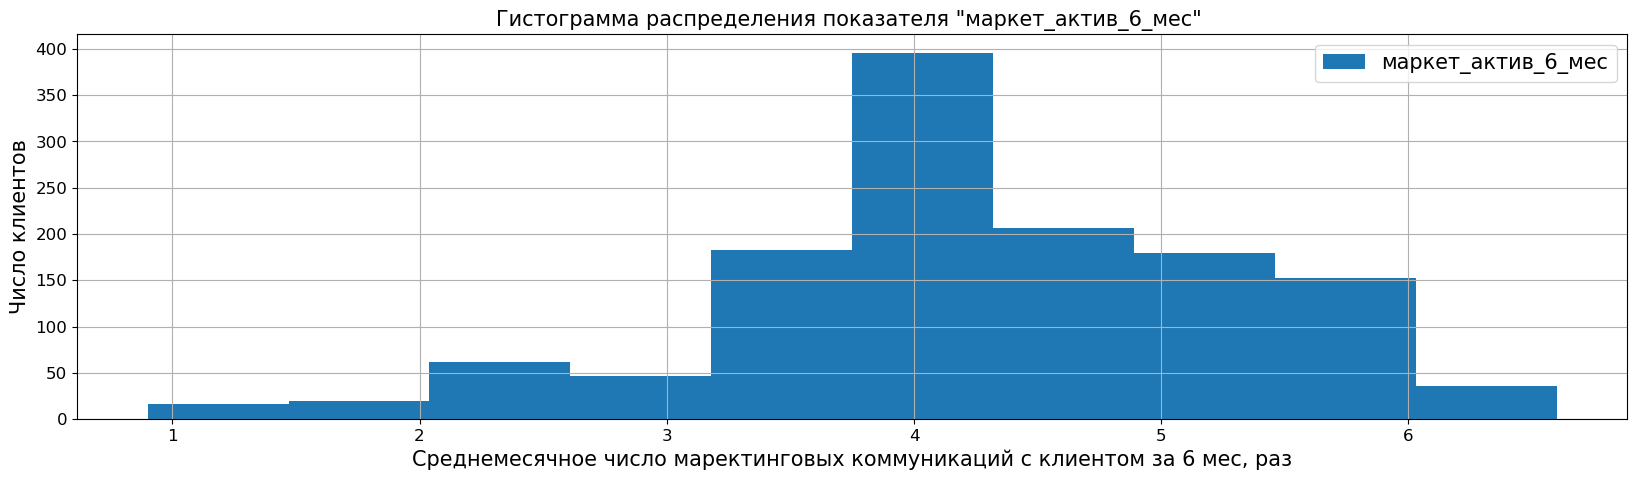

Статистика: count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


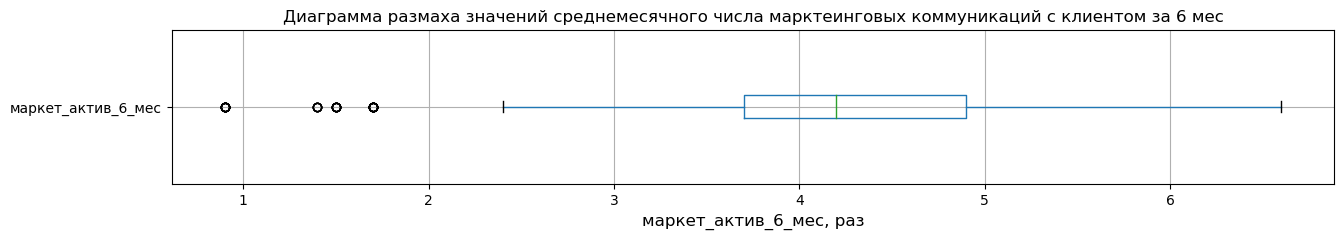

In [20]:
market_file['маркет_актив_6_мес'].plot(kind = 'hist', bins = 10, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "маркет_актив_6_мес" ', fontsize=15)
plt.xlabel('Среднемесячное число маректинговых коммуникаций с клиентом за 6 мес, раз', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['маркет_актив_6_мес']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений среднемесячного числа марктеинговых коммуникаций с клиентом за 6 мес')
ax.set_xlabel('маркет_актив_6_мес, раз', fontsize = 12)

;

print('Статистика:', market_file['маркет_актив_6_мес'].describe())

Среднее за 6 месяцев число коммуникаций с клиентом - 4 раза, отклонение +-1 в обе стороны. Максимальное среднее число взаимодействий за 6 месяцев - 6 раз. Значения 1-2 раза за 6 месяцев встречаются очень редко. Возможно, это коммуникации с клиентами, зарегистрированными относительно недавно.

Отобразим количество маркетинговых коммуникаций в текущем месяце.

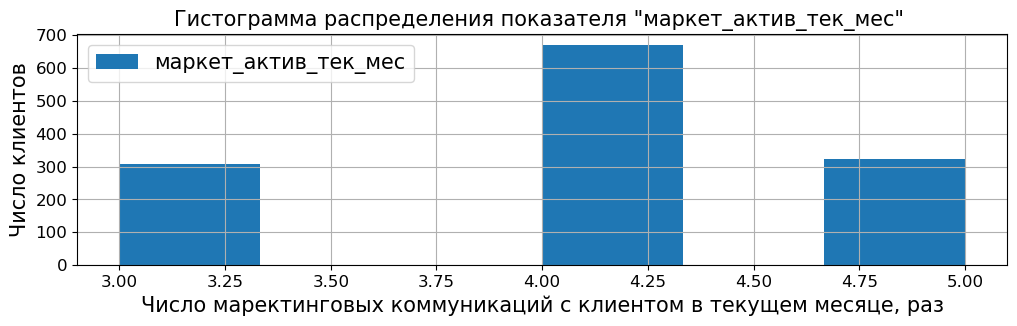

Статистика: count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


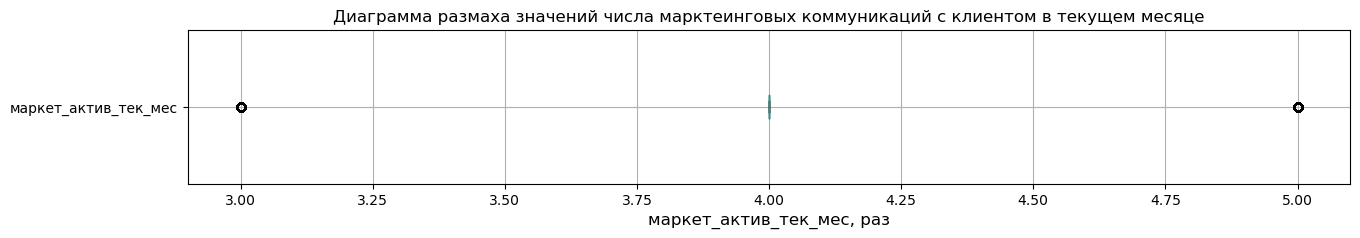

In [17]:
market_file['маркет_актив_тек_мес'].plot(kind = 'hist', bins = 6, figsize = (12, 3), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "маркет_актив_тек_мес" ', fontsize=15)
plt.xlabel('Число маректинговых коммуникаций с клиентом в текущем месяце, раз', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['маркет_актив_тек_мес']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений числа марктеинговых коммуникаций с клиентом в текущем месяце')
ax.set_xlabel('маркет_актив_тек_мес, раз', fontsize = 12)

;

print('Статистика:', market_file['маркет_актив_тек_мес'].describe())

По графикам видно, чтораспределение числа коммуникаций с клиентами в текущем месяце имеет дискретный характер, лучше посмотреть методом подсчета значений.

In [28]:
market_file['маркет_актив_тек_мес'].value_counts()

маркет_актив_тек_мес
4    669
5    323
3    308
Name: count, dtype: int64

В текущем месяце с половиной клиентов взаимодействовали по 4 раза, с четвертью - по 3 раза и с дургой четвертью - по 5 раз.

Смотрим распределение показателя длительности пребывания клиента на сайте с момента регистрации.

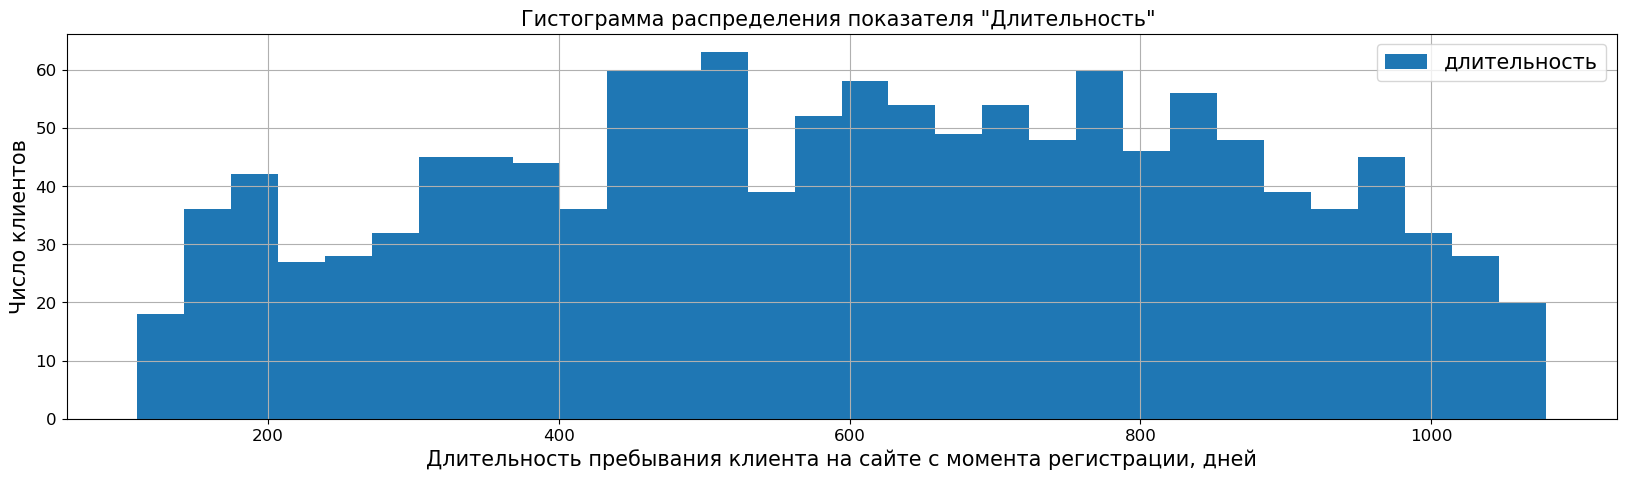

Статистика: count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


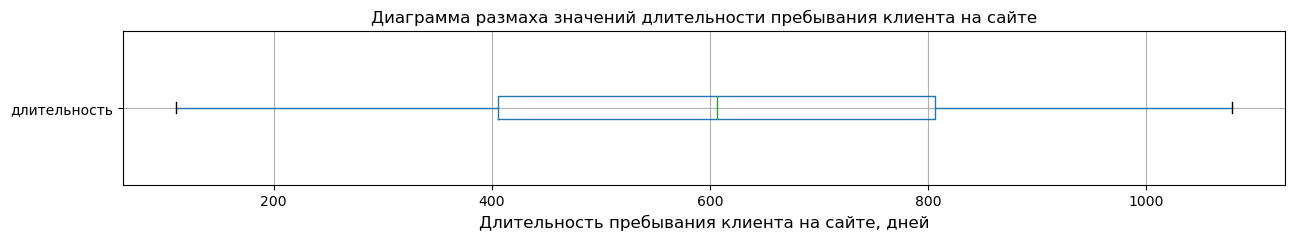

In [18]:
market_file['длительность'].plot(kind = 'hist', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Длительность" ', fontsize=15)
plt.xlabel('Длительность пребывания клиента на сайте с момента регистрации, дней', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['длительность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений длительности пребывания клиента на сайте')
ax.set_xlabel('Длительность пребывания клиента на сайте, дней', fontsize = 12)

;

print('Статистика:', market_file['длительность'].describe())

Средняя длительность пребывания клиентов на сайте  - 606 дней, половина клиентов зарегистрированы на сайте от 400 до 800 дней. Есть клиенты, зарегистрированные 100 дней назад (мимнимум) и 1100 дней (максимум). Разброс значений ощутимый - 250 дней.

Смотрим показатель среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев.

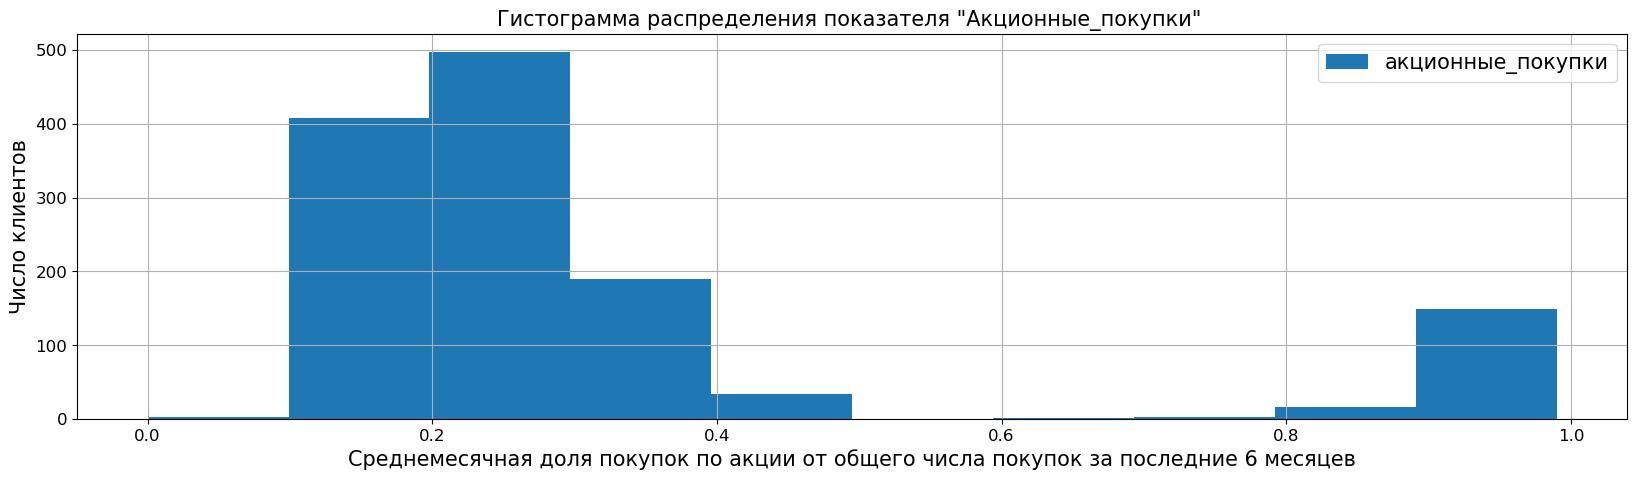

Статистика: count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


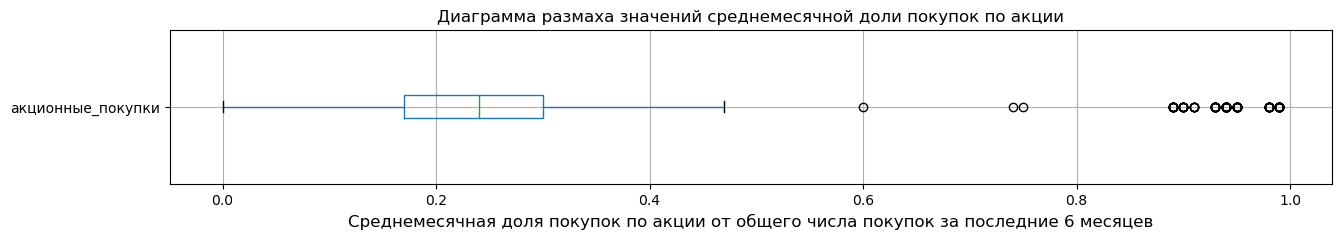

In [19]:
market_file['акционные_покупки'].plot(kind = 'hist', bins = 10, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Акционные_покупки" ', fontsize=15)
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['акционные_покупки']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений среднемесячной доли покупок по акции')
ax.set_xlabel('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев', fontsize = 12)

;

print('Статистика:', market_file['акционные_покупки'].describe())

Значительная часть клиентов (более половины) покупает по акции 10-30% от общего числа покупок. На гистограмме видны 2 диапазона значений показателя: [0.1, 0.4] и [0.8, 1]. 

Это явный намек на перевод признака в категориальный: 2 диапазона значений делят информацию на 2 кластера, и первый диапазон ощутимо преобладает.

Смотрим показатель среднего числа просмотренных категорий за визит.

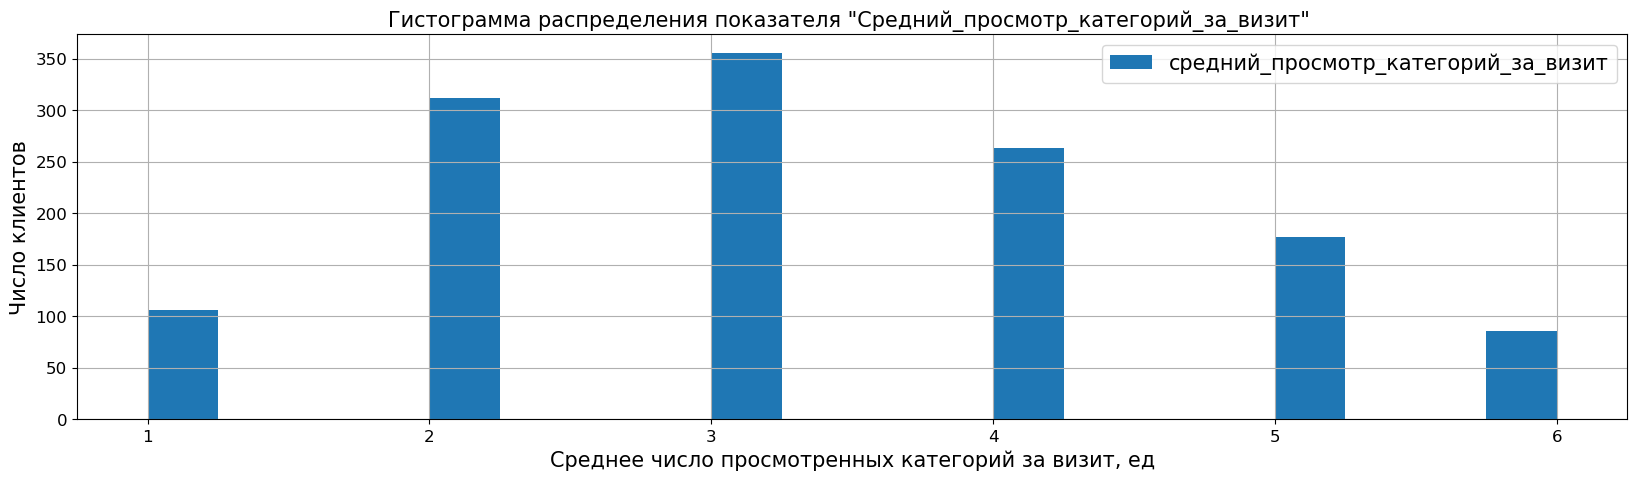

Статистика: count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


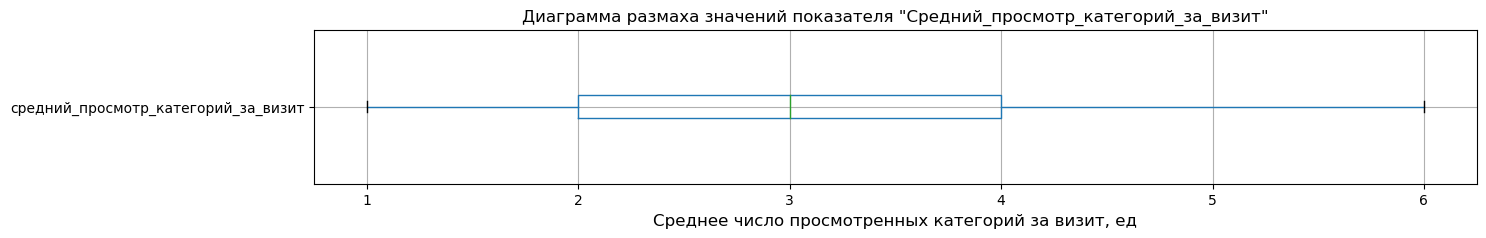

In [20]:
market_file['средний_просмотр_категорий_за_визит'].plot(kind = 'hist', bins = 20, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Средний_просмотр_категорий_за_визит" ', fontsize=15)
plt.xlabel('Среднее число просмотренных категорий за визит, ед', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['средний_просмотр_категорий_за_визит']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Средний_просмотр_категорий_за_визит"')
ax.set_xlabel('Среднее число просмотренных категорий за визит, ед', fontsize = 12)

;

print('Статистика:', market_file['средний_просмотр_категорий_за_визит'].describe())

Среднее число просмотренных категорий - 3, половина клиентов за визит просматривают 2-4 категории, редко смотрят по 1 и по 6 категорий.

Смотрим показатель "Общее число неоплаченных товаров в корзине за последние 3 месяца".

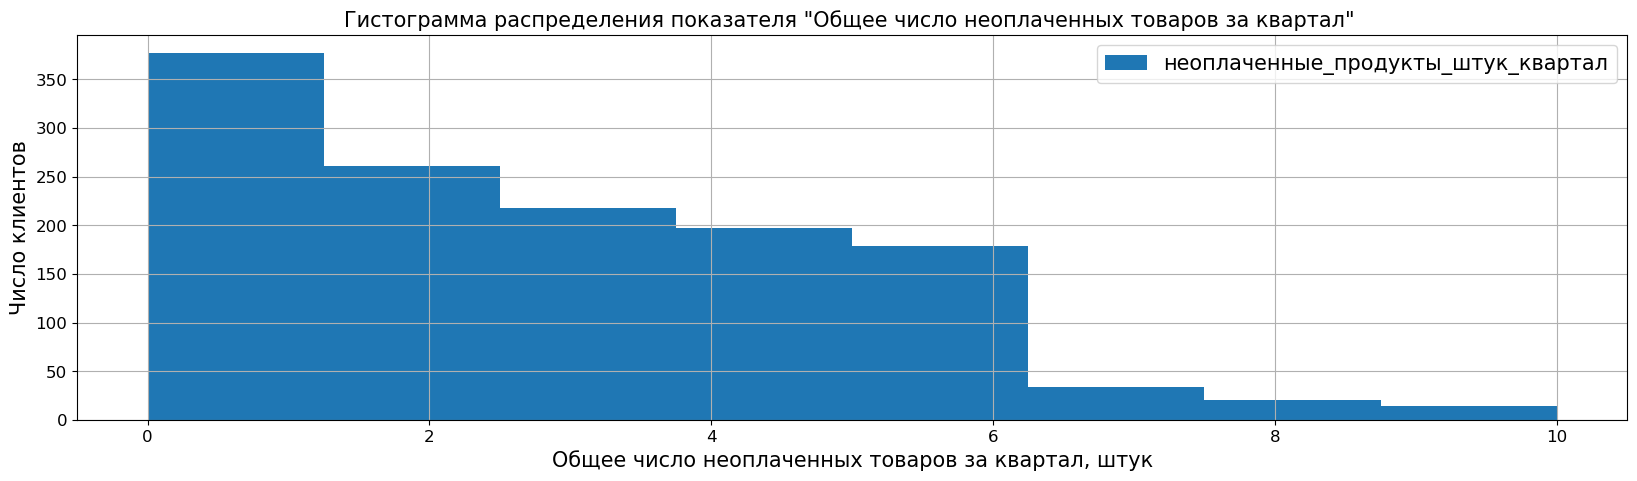

Статистика: count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


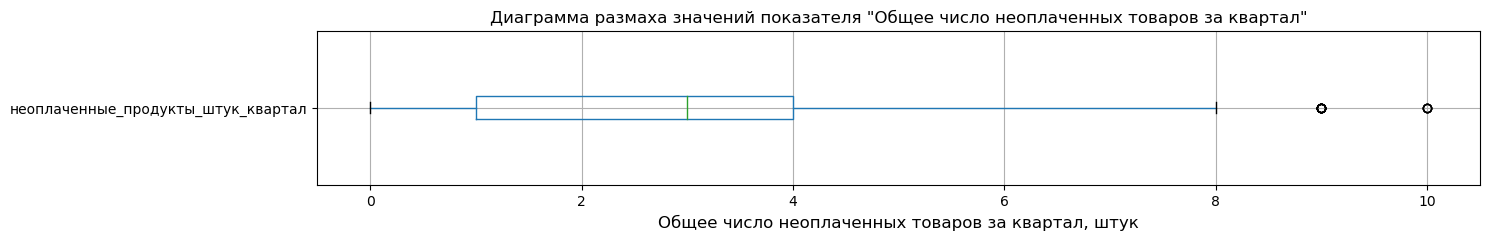

In [21]:
market_file['неоплаченные_продукты_штук_квартал'].plot(kind = 'hist', bins = 8, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Общее число неоплаченных товаров за квартал" ', fontsize=15)
plt.xlabel('Общее число неоплаченных товаров за квартал, штук', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['неоплаченные_продукты_штук_квартал']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Общее число неоплаченных товаров за квартал"')
ax.set_xlabel('Общее число неоплаченных товаров за квартал, штук', fontsize = 12)

;

print('Статистика:', market_file['неоплаченные_продукты_штук_квартал'].describe())

In [22]:
market_file['неоплаченные_продукты_штук_квартал'].value_counts()

неоплаченные_продукты_штук_квартал
2     261
1     261
3     218
4     197
5     135
0     116
6      44
7      34
8      20
9      10
10      4
Name: count, dtype: int64

Почти 65% клиентов держат в корзине 1-4 неоплаченных товаров, чаще всего не оплачены 1-2 товара.

Смотрим показатель числа сбоев, которые коснулись покупателя во время посещения сайта.

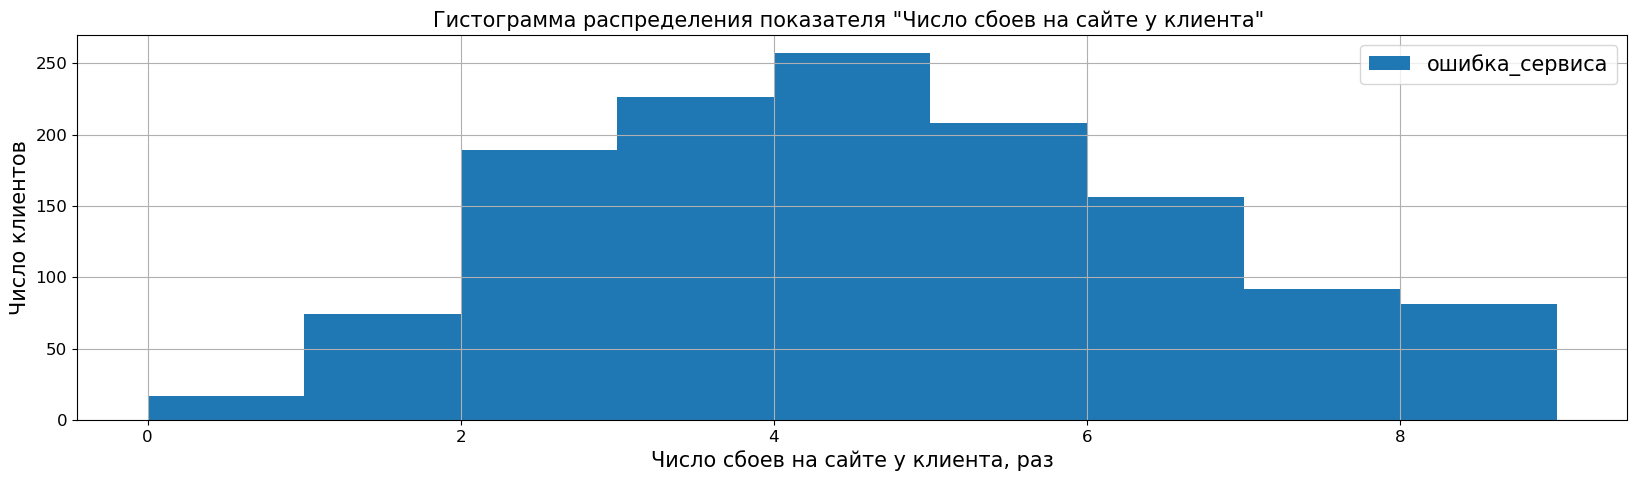

Статистика: count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


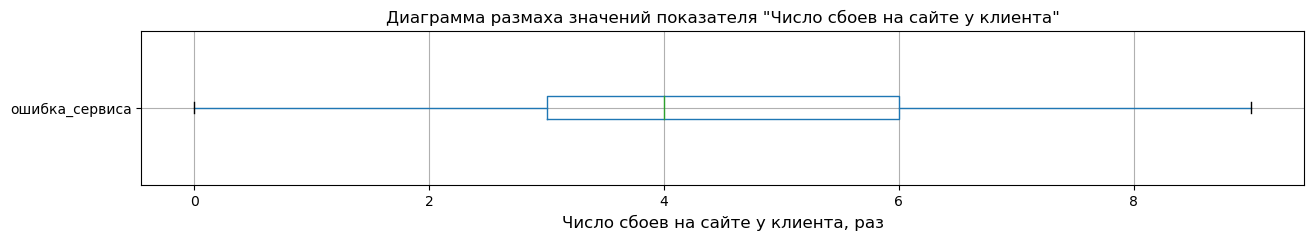

In [23]:
market_file['ошибка_сервиса'].plot(kind = 'hist', bins = 9, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Число сбоев на сайте у клиента" ', fontsize=15)
plt.xlabel('Число сбоев на сайте у клиента, раз', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['ошибка_сервиса']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Число сбоев на сайте у клиента"')
ax.set_xlabel('Число сбоев на сайте у клиента, раз', fontsize = 12)

;

print('Статистика:', market_file['ошибка_сервиса'].describe())

Самое распространенное число сбоев на сайте - 4, у половины клиентов значения сбоев варьируется от 3 до 6. Редко встречаются значения 0-1, 8-9 раз.

Для большей показательности я бы сделала новый признак "Число сбоев в месяц", т к есть клиенты, зарегистрированнеы на сайте 100 дней назад, а есть клиенты, зарегистрированные 1100 дней назад. Правильно было бы анализировать не абсолютный, а средний показатель числа сбоев работы на сайте.

Смотрим показатель среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

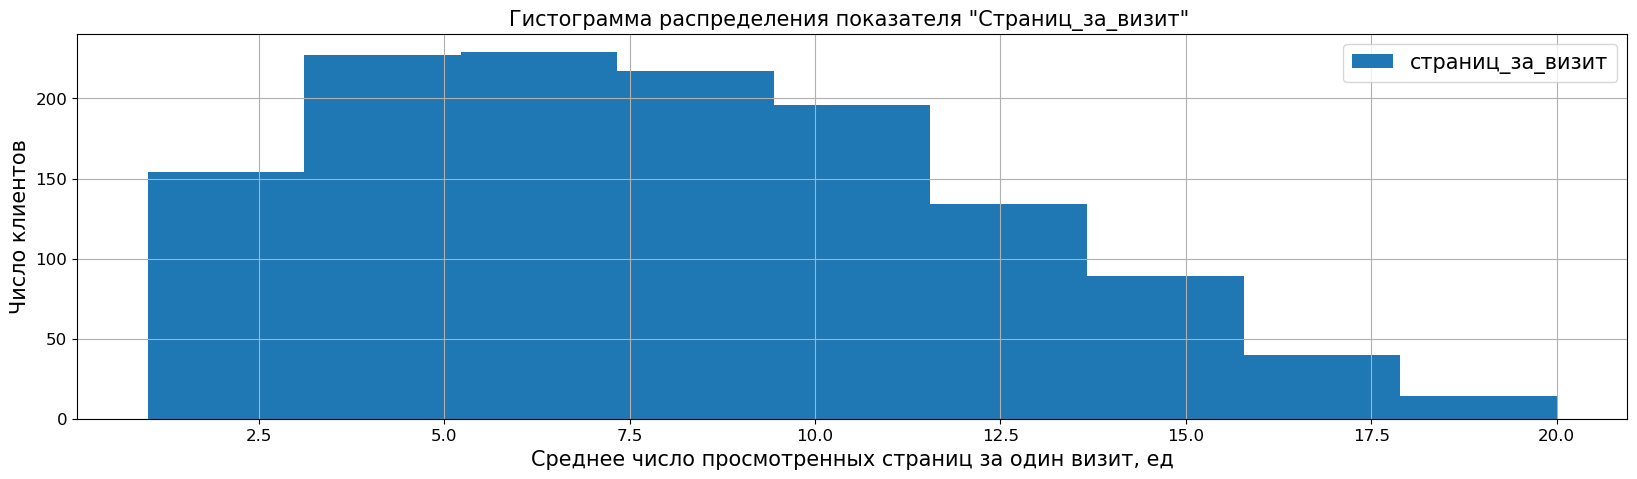

Статистика: count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


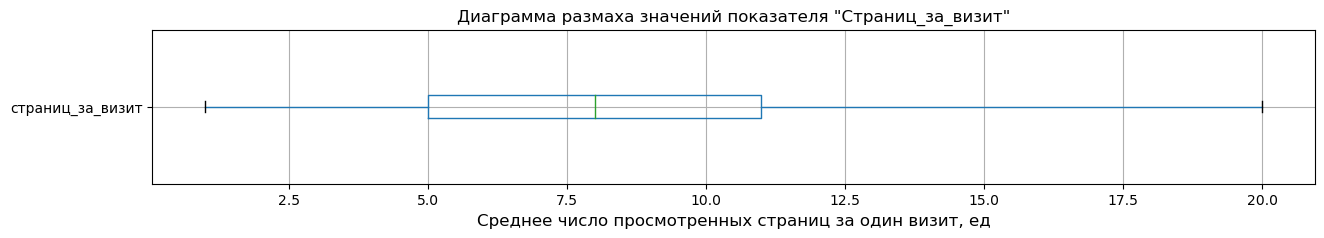

In [24]:
market_file['страниц_за_визит'].plot(kind = 'hist', bins = 9, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Страниц_за_визит" ', fontsize=15)
plt.xlabel('Среднее число просмотренных страниц за один визит, ед', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = market_file[['страниц_за_визит']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Страниц_за_визит"')
ax.set_xlabel('Среднее число просмотренных страниц за один визит, ед', fontsize = 12)

;

print('Статистика:', market_file['страниц_за_визит'].describe())

Среднее число просмотренных за визит страниц - 8, половина покупателей просматривают от 5 до 11 страниц.

Переходим к анализу категориальных признаков. Построим столбчатые диаграммы для показателей
- Покупательская активность;
- Тип сервиса;
- Разрешить сообщать;
- Популярная_категория.


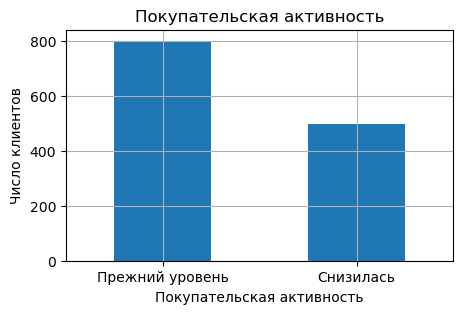

In [25]:
market_file['покупательская активность'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Покупательская активность',\
                                                             xlabel='Покупательская активность', \
                                                             ylabel='Число клиентов', grid = True,
                                                             rot=0);

У 38% клиетов покупатлеьская активность снизилась, у 62% осталась на прежнем уровне.

тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

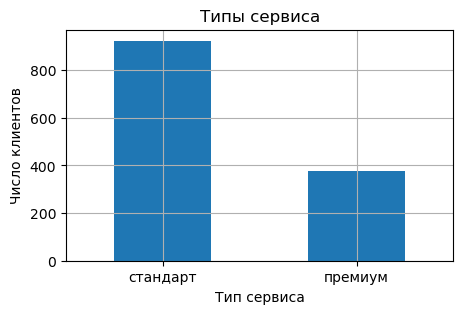

In [26]:
display(market_file['тип сервиса'].value_counts())
market_file['тип сервиса'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Типы сервиса',\
                                                             xlabel='Тип сервиса', \
                                                             ylabel='Число клиентов', grid = True, rot=0);

71% клиентов имеют подписку "Стандарт", 29% - "Премиум".

разрешить сообщать
да     962
нет    338
Name: count, dtype: int64

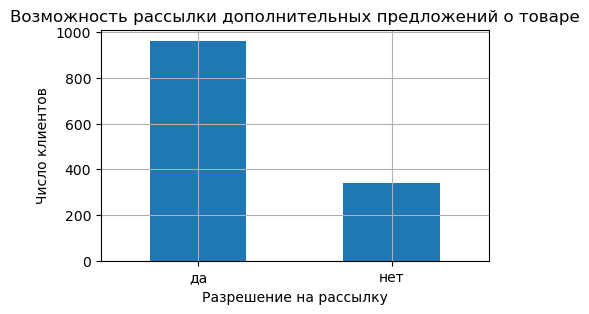

In [27]:
display(market_file['разрешить сообщать'].value_counts())
market_file['разрешить сообщать'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Возможность рассылки дополнительных предложений о товаре',\
                                                             xlabel='Разрешение на рассылку', \
                                                             ylabel='Число клиентов', grid = True, rot=0);

74% клиентов разрешили сообщать о дополнительных предложениях, 26% не разрешили.

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

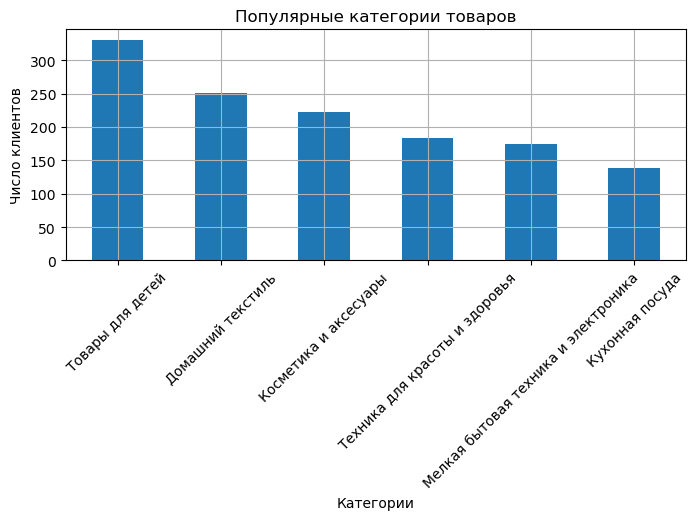

In [29]:
display(market_file['популярная_категория'].value_counts())
market_file['популярная_категория'].value_counts().plot(kind='bar', figsize = (8, 3),\
                                                             title = 'Популярные категории товаров',\
                                                             xlabel='Категории', \
                                                             ylabel='Число клиентов', grid = True, rot=45);

Самая популярная категория (четверть покупателей) - "Товары для детей".

Сгруппируем данные из таблицы market_money по месяцам.

период
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6909449.1
Name: выручка, dtype: float64

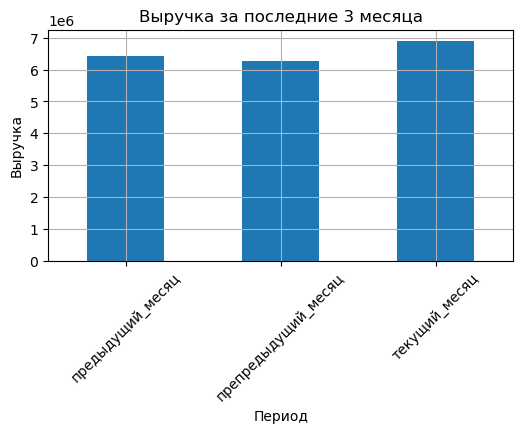

In [30]:
money_market_periods = market_money.groupby('период')['выручка'].sum().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Выручка за последние 3 месяца',\
                                                             xlabel='Период', \
                                                             ylabel='Выручка',\
                                                             grid = True, rot=45);

display(market_money.groupby('период')['выручка'].sum())

В текущем месяце показатель выручки немного вырос (на 7%) по сравнению с предыдущим месяцем. За прошлый период выручка тоже немного подросла (на 2%).

In [52]:
display(market_money.head())

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Посмотрим распределение выручки по месяцам. Построим гистограммы и диаграммы размаха показателей выручки по каждому из трех месяцев.

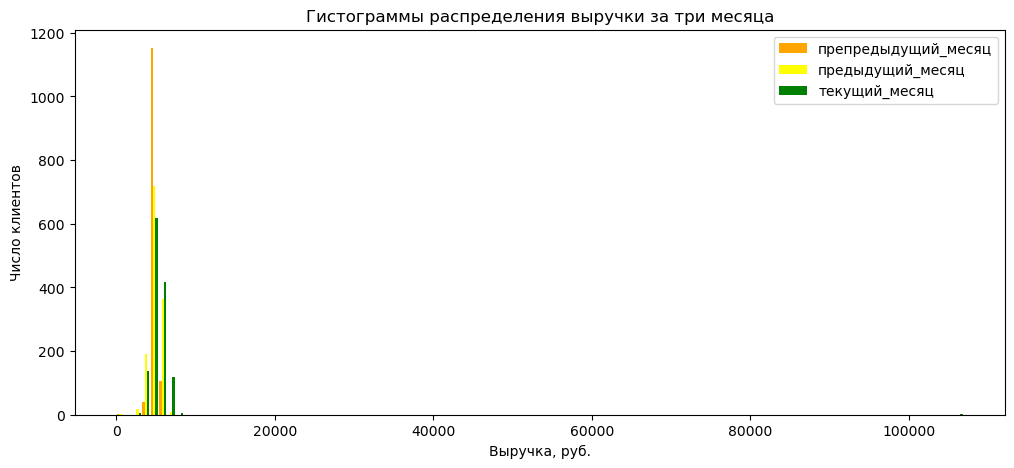

In [31]:
x1_ = list(market_money[market_money['период'] == 'препредыдущий_месяц']['выручка'])
x2_ = list(market_money[market_money['период'] == 'предыдущий_месяц']['выручка'])
x3_ = list(market_money[market_money['период'] == 'текущий_месяц']['выручка'])

colors = ['orange', 'yellow', 'green']
names = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

k = plt.figure()
k.set_figwidth(12)
k.set_figheight(5)
plt.hist([x1_, x2_, x3_], bins = 100,
         color = colors, label=names)

plt.legend()
plt.title('Гистограммы распределения выручки за три месяца')
plt.xlabel('Выручка, руб.')
plt.ylabel('Число клиентов')
plt.show();
          

Гистограммы выглядят странно. Если справа такой большой пустой участок, значит, где-то имеются выбросы, не позволяющие значениям равномерно распределиться по всей оси ох. Посмотрим диаграммы размаха.

Статистика: count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: выручка, dtype: float64


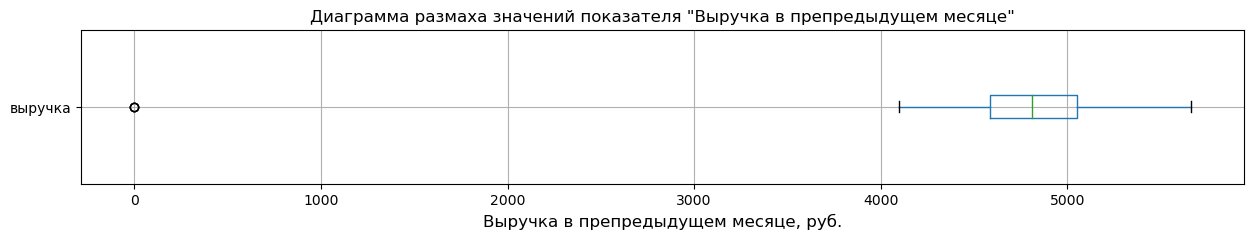

In [32]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'препредыдущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в препредыдущем месяце"')
ax.set_xlabel('Выручка в препредыдущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'препредыдущий_месяц']['выручка'].describe())

Статистика: count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: выручка, dtype: float64


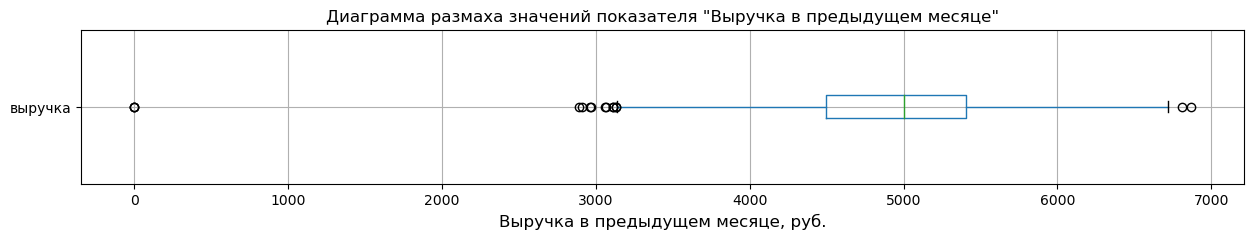

In [55]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'предыдущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в предыдущем месяце"')
ax.set_xlabel('Выручка в предыдущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'предыдущий_месяц']['выручка'].describe())

Статистика: count      1300.000000
mean       5314.960846
std        2939.708156
min        2758.700000
25%        4706.050000
50%        5179.950000
75%        5761.725000
max      106862.200000
Name: выручка, dtype: float64


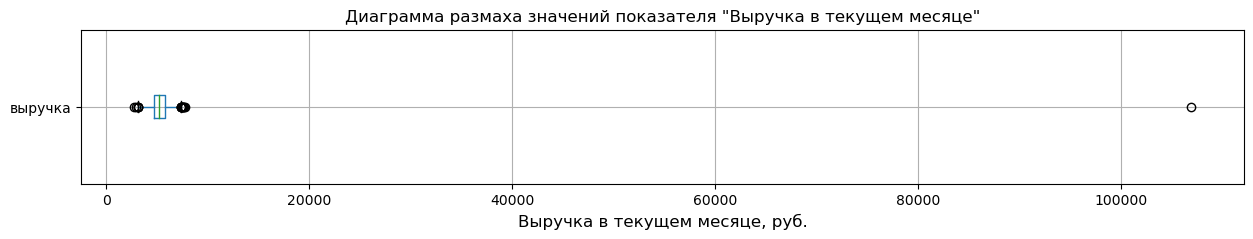

In [56]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'текущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в текущем месяце"')
ax.set_xlabel('Выручка в текущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'текущий_месяц']['выручка'].describe())

На диаграммах размаха видим, что в препредыдущем и предыдущем месяцах выручка распределена относительно равномерно:  среднее 4800-5000, максимальные значения - 5600-6900 руб. В этих же периодах присутствуют клиенты с нулевой выручкой, которые нам не понадобятся для дальнейшего исследования, но которые тянут покзатели статистики на себя.
А в текущем месяце видим аномальное значение выручки более 100000 руб, которое тянет на себя статистику и не дает посмотреть распределения значений в нормальном диапазоне значений. Уберем аномалию и нулевые значения выручки и построим гистограммы на обновленных данных.

Перед удалением нулевых значений выручки посмотрим id неактивных клиентов, чтобы далее убрать их из другних таблиц.

In [21]:
clients_to_drop = market_money.loc[market_money['выручка'] == 0]
display(clients_to_drop)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Удалим клиентов с отсутствием покупательской активности из всех таблиц.

In [22]:
market_money = market_money[(market_money['id'] != 215348)&(market_money['id'] != 215357)&(market_money['id'] != 215359)]
market_time = market_time[(market_time['id'] != 215348)&(market_time['id'] != 215357)&(market_time['id'] != 215359)]
market_file = market_file[(market_file['id'] != 215348)&(market_file['id'] != 215357)&(market_file['id'] != 215359)]
money = money[(money['id'] != 215348)&(money['id'] != 215357)&(money['id'] != 215359)]

Найдем id клиентов с аномальным значением выручки (более 8000 руб.)

In [23]:
clients_to_drop_2 = market_money.loc[market_money['выручка'] > 8000]
display(clients_to_drop_2)

,id,период,выручка
98,215380,текущий_месяц,106862.2


Удалим клиента-аномалию из всех таблиц.

In [24]:
market_money = market_money[market_money['id'] != 215380]
market_time = market_time[market_time['id'] != 215380]
market_file = market_file[market_file['id'] != 215380]
money = money[money['id'] != 215380]

Диаграммы размаха после удаления аномалии и нулевых значений:

Статистика: count    1296.000000
mean     5238.096065
std       834.318717
min      2758.700000
25%      4706.050000
50%      5179.950000
75%      5759.275000
max      7799.400000
Name: выручка, dtype: float64


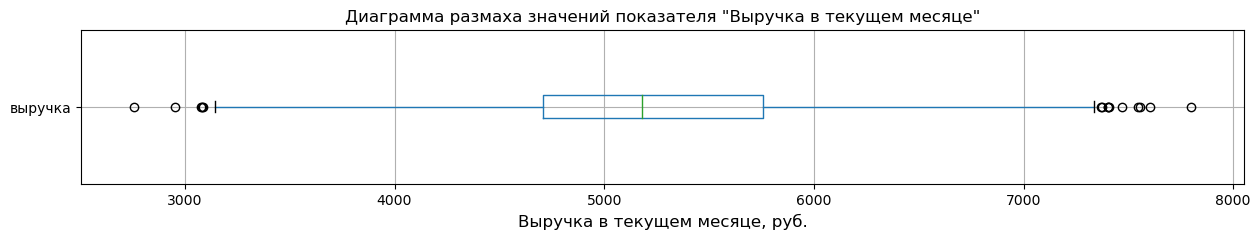

In [25]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'текущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в текущем месяце"')
ax.set_xlabel('Выручка в текущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'текущий_месяц']['выручка'].describe())

Статистика: count    1296.000000
mean     4947.468750
std       700.797239
min      2890.000000
25%      4498.125000
50%      5005.500000
75%      5405.625000
max      6869.500000
Name: выручка, dtype: float64


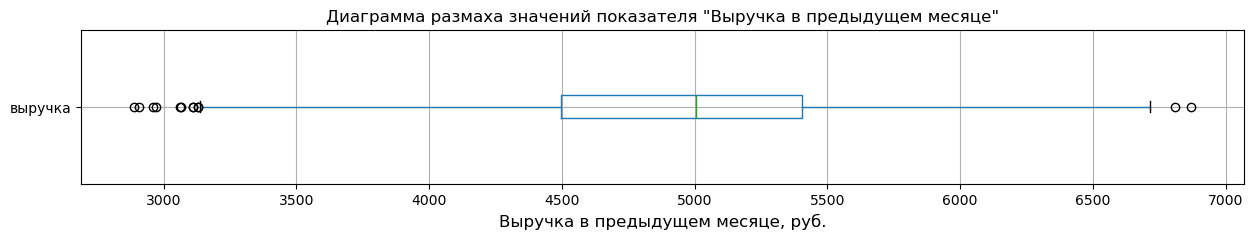

In [26]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'предыдущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в предыдущем месяце"')
ax.set_xlabel('Выручка в предыдущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'предыдущий_месяц']['выручка'].describe())

Статистика: count    1296.000000
mean     4836.202160
std       333.514091
min      4098.000000
25%      4584.500000
50%      4810.500000
75%      5056.000000
max      5663.000000
Name: выручка, dtype: float64


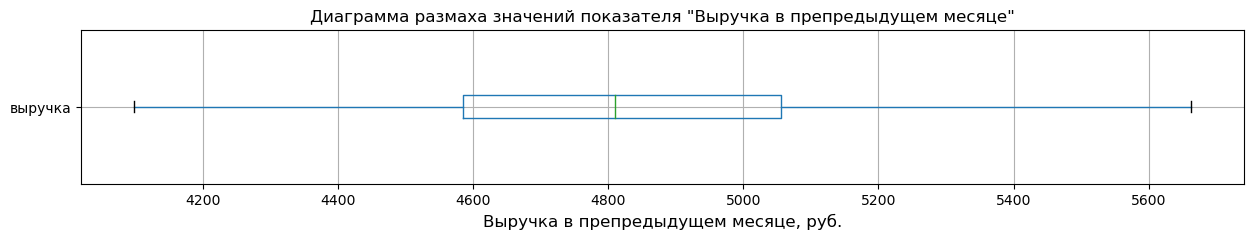

In [27]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_money.loc[market_money['период'] == 'препредыдущий_месяц'][['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Выручка в препредыдущем месяце"')
ax.set_xlabel('Выручка в препредыдущем месяце, руб.', fontsize = 12)

;

print('Статистика:', market_money.loc[market_money['период'] == 'препредыдущий_месяц']['выручка'].describe())

Средний показатель выручки вырос в текущем месяце

Гистограммы после удаления аномалии:

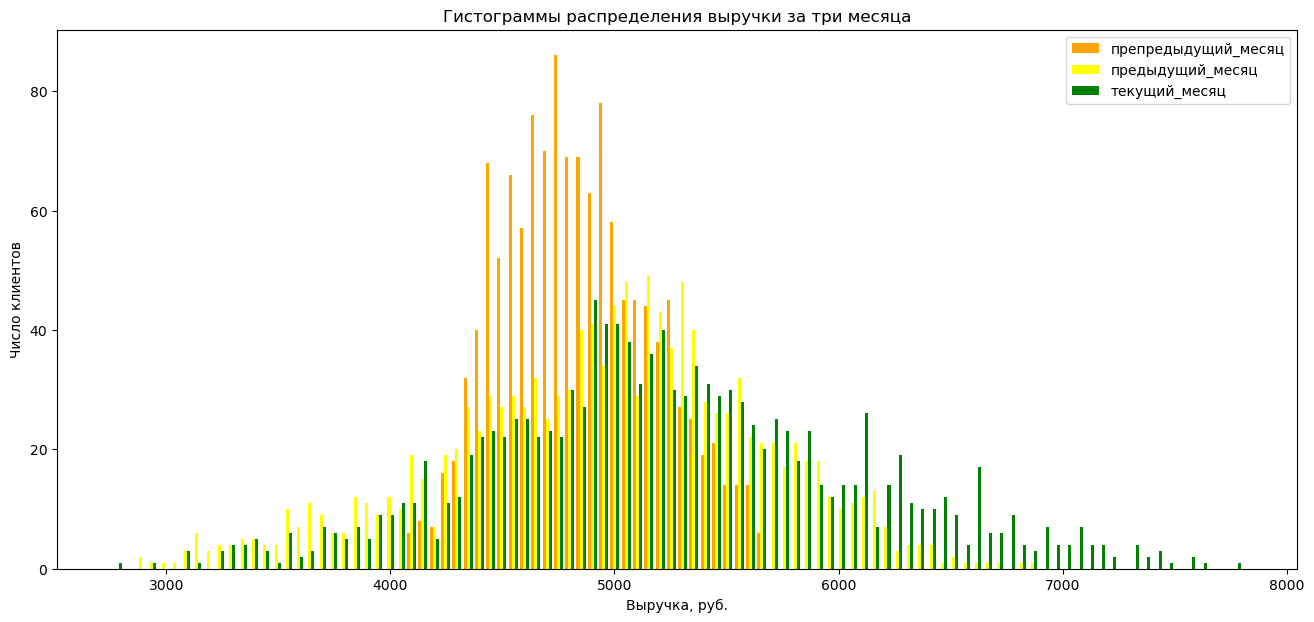

In [28]:
x1_ = list(market_money[market_money['период'] == 'препредыдущий_месяц']['выручка'])
x2_ = list(market_money[market_money['период'] == 'предыдущий_месяц']['выручка'])
x3_ = list(market_money[market_money['период'] == 'текущий_месяц']['выручка'])

colors = ['orange', 'yellow', 'green']
names = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

k = plt.figure()
k.set_figwidth(16)
k.set_figheight(7)
plt.hist([x1_, x2_, x3_], bins = 100,
         color = colors, label=names)

plt.legend()
plt.title('Гистограммы распределения выручки за три месяца')
plt.xlabel('Выручка, руб.')
plt.ylabel('Число клиентов')
plt.show();
          

После удаления аномалий и неактивных клиентов (с нулевой выручкой) видим более наглядное распределение показателей выручки за 3 месяца. Средние значения выручки в текущем и предыдущем месяцах соспоставимы и равны 5000-5200 руб в месяц, характер распределения и отклонения от среднего в текущем и предыдущем месяцах сопоставимы.
Текущий и предыдущий показатель выросли по сравнению с препредыдущим месяцем - это отчетливо видно на гистограммах: более высокие пики гистограммы в препредыдущем месяце означают, что бОльшая часть клиентов демонстрировала меньшие показатели выручки (~4400-5000 тыс.). И максимальный показатель выручки в том периоде составил около 5500 руб., в то время как последние два месяца максимальные знаяения выручки доходили до 7800 руб.

Проанализируем данные из файла "market_time": посмотрим распределение времени, проведенного клиентами на сайте.

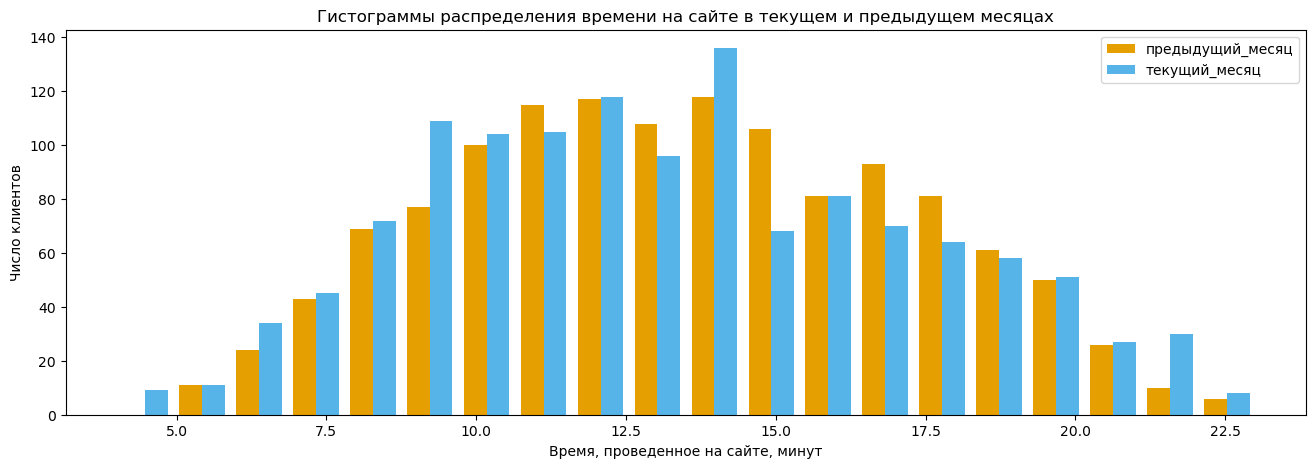

<Figure size 1200x1000 with 0 Axes>

In [29]:
x1 = list(market_time[market_time['период'] == 'предыдущий_месяц']['минут'])
x2 = list(market_time[market_time['период'] == 'текущий_месяц']['минут'])

colors = ['#E69F00', '#56B4E9']
names = ['предыдущий_месяц', 'текущий_месяц']

k = plt.figure()
k.set_figwidth(16)
k.set_figheight(5)
plt.hist([x1, x2], bins = 20, 
         color = colors, label=names)

plt.legend()
plt.title('Гистограммы распределения времени на сайте в текущем и предыдущем месяцах')
plt.xlabel('Время, проведенное на сайте, минут')
plt.ylabel('Число клиентов')
plt.figure(figsize=(12, 10))
plt.show();
          


Статистика: count    1296.000000
mean       13.210648
std         4.221794
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


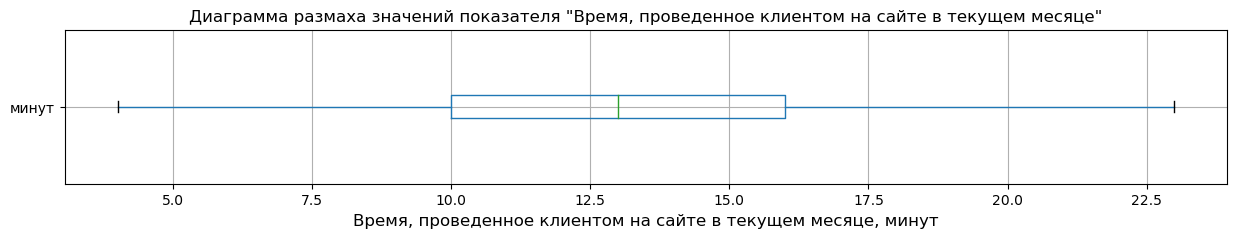

In [30]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_time.loc[market_time['период'] == 'текущий_месяц'][['минут']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Время, проведенное клиентом на сайте в текущем месяце"')
ax.set_xlabel('Время, проведенное клиентом на сайте в текущем месяце, минут', fontsize = 12)

;

print('Статистика:', market_time.loc[market_time['период'] == 'текущий_месяц']['минут'].describe())

Статистика: count    1296.000000
mean       13.470679
std         3.937630
min         5.000000
25%        10.750000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут, dtype: float64


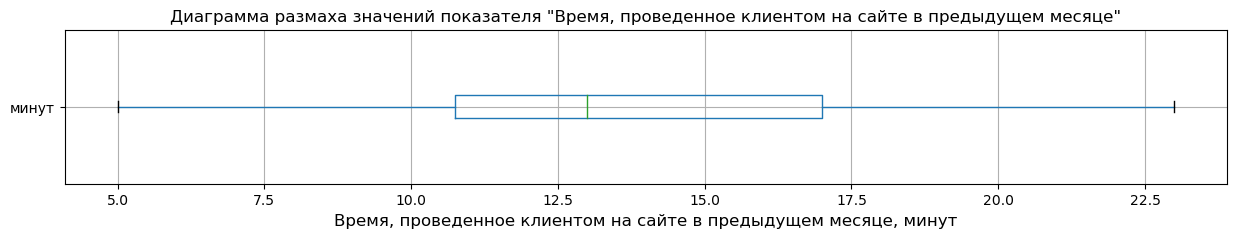

In [31]:
fig, ax = plt.subplots(figsize = (15,2))
ax = market_time.loc[market_time['период'] == 'предыдущий_месяц'][['минут']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Время, проведенное клиентом на сайте в предыдущем месяце"')
ax.set_xlabel('Время, проведенное клиентом на сайте в предыдущем месяце, минут', fontsize = 12)

;

print('Статистика:', market_time.loc[market_time['период'] == 'предыдущий_месяц']['минут'].describe())

Глядя на гистограммы распределения и диаграммы размаха времени, проведенного клиентами на сайте, видим, что среднее время на сайте по сравнению с предыдущим месяцем существенно не поменялось, ощутимых изменений в статистике времени на сайте по сравнению с предыдущим периодом не произошло.

Проанализируем информацию о прибыльности клиентов на основе данных из таблицы 'money'.

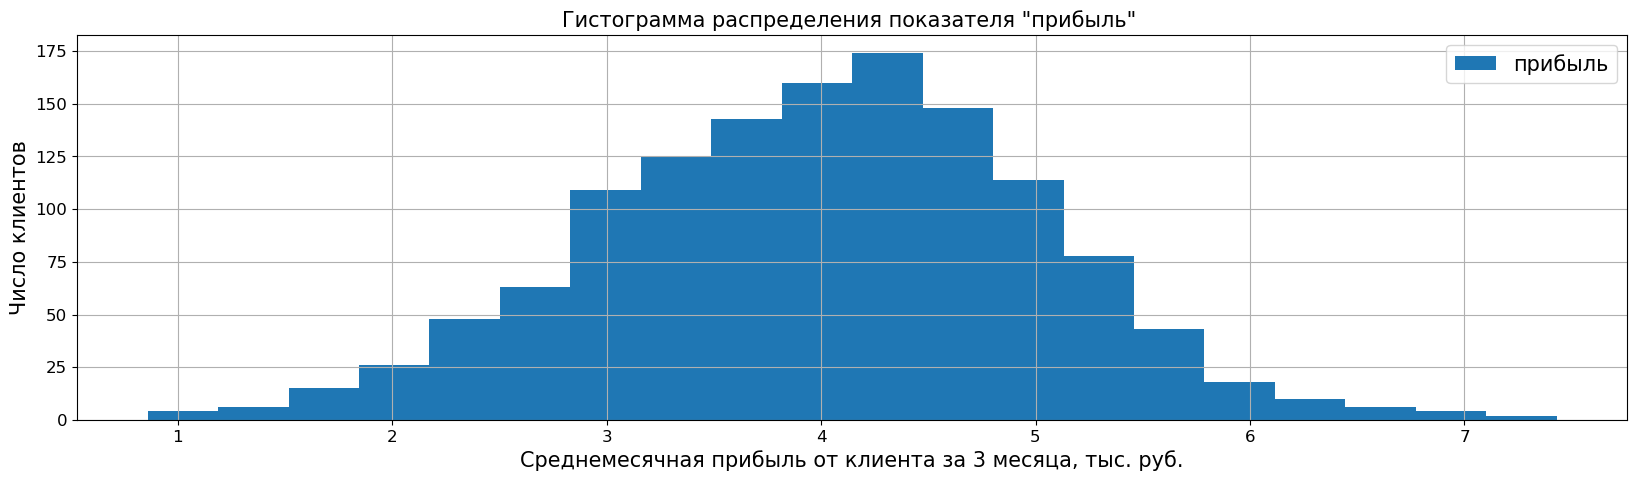

Статистика: count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


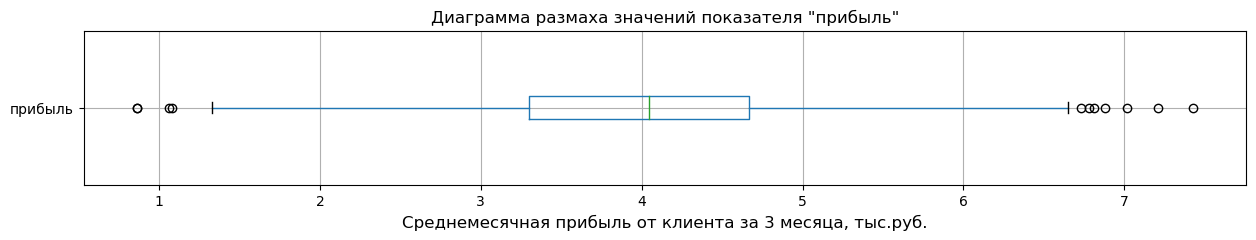

In [44]:
money['прибыль'].plot(kind = 'hist', bins = 20, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "прибыль" ', fontsize=15)
plt.xlabel('Среднемесячная прибыль от клиента за 3 месяца, тыс. руб.', fontsize = 15)
plt.ylabel('Число клиентов', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = money[['прибыль']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "прибыль"')
ax.set_xlabel('Среднемесячная прибыль от клиента за 3 месяца, тыс.руб.', fontsize = 12)

;

print('Статистика:', money['прибыль'].describe())

Средемесячная прибыль, которую приносит клиент - 4 тыс.руб., дисперсия не очень высокая, есть немного выбросов: клиентов с низкой прибылью и прибылью выше 6,5 тыс. рублей.

**Выводы по итогам исследовательского анализа данных:**

***1)*** Средняя длительность пребывания клиентов на сайте - 606 дней, половина клиентов зарегистрированы на сайте от 400 до 800 дней. Есть клиенты, зарегистрированные 100 дней назад (мимнимум) и 1100 дней (максимум). 

***2)*** Значительная часть клиентов (более половины) покупает по акции 10-30% от общего числа покупок. ВЫделяются 2 диапазона значений показателя доли покупок по акциям: [0.1, 0.4] и [0.8, 1].

***3)*** Среднее число товаров, просматриваемых клиентами за визит, - 3, половина клиентов за визит просматривают 2-4 категории, редко смотрят по 1 и по 6 категорий. Среднее число просмотренных за визит страниц - 8, половина покупателей просматривают от 5 до 11 страниц. Почти 65% клиентов держат в корзине 1-4 неоплаченных товаров, чаще всего не оплачены 1-2 товара.

***4)*** Самое распространенное число сбоев на сайте - 4, у половины клиентов значения сбоев варьируется от 3 до 6. Редко встречаются значения 0-1, 8-9 раз.

Для большей показательности я бы сделала новый признак "Число сбоев в месяц", т к есть клиенты, зарегистрированнеы на сайте 100 дней назад, а есть клиенты, зарегистрированные 1100 дней назад. Правильно было бы анализировать не абсолютный, а средний показатель числа сбоев работы на сайте.

***5)*** Итоги анализа категориальных признаков. У 38% клиетов покупатлеьская активность снизилась, у 62% осталась на прежнем уровне. 71% клиентов имеют подписку "Стандарт", 29% - "Премиум". В текущем месяце показатель выручки немного вырос (на 7%) по сравнению с предыдущим месяцем. За прошлый период выручка тоже немного подросла (на 2%). Самая популярная категория (у четверти покупателей) - "Товары для детей".

***6)*** Среднее время, проводимое клиентоами на сайте, - 13 минут, чаще всего клиенты проводят на сайте - 11-17 минут.

***7)*** Убрали из файлов 3 клиентов с отсутствием покупательской активности в один из 3 последних месяцев. Убрали аномалию - клиента со значением выручки боллее 100 тыс.руб. После чего проанализировали показатели выручки за 3 последних месяца.
Средние показатели выручки в текущем и предыдущем месяцах выросли на 7,5% (с 4800 до 5160 руб.). Максимальные знаяения выручки в текущем месяце выросли на 27% (с 5500 до 7000 руб.). 

## **Шаг 4. Объединение таблиц**

In [32]:
market_1 = pd.merge(market_file, market_time, on='id', how = 'outer')
market_united = market_1.pivot_table(index = market_file.columns.to_list(),
                                    columns = 'период',
                                    values = 'минут').reset_index()
market_united.columns.name = None
market_united.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [46]:
market_united.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [33]:
market_united = market_united.rename(columns = 
                                    {'предыдущий_месяц': 'минуты_пред_мес',
                                    'текущий_месяц': 'минуты_текущий_мес'})
market_united.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [25]:
market_united.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [34]:
market_2 = pd.merge(market_united, market_money, on = 'id', how = 'outer')
market_united = market_2.pivot_table(index = market_united.columns.tolist(),
                                    columns = 'период',
                                    values = 'выручка').reset_index()
market_united.columns.name = None
market_united.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [35]:
market_united = market_united.rename(columns = 
                                     {'предыдущий_месяц': 'выручка_пред_мес',
                                     'текущий_месяц': 'выручка_текущий_мес',
                                     'препредыдущий_месяц': 'выручка_препред_мес'})
market_united.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [64]:
display(market_united.head())

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_пред_мес,выручка_препред_мес,выручка_текущий_мес
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


Переведем столбец 'id' в индексы:


In [36]:
market_united = market_united.set_index('id')

In [37]:
market_united.tail()

,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_пред_мес,выручка_препред_мес,выручка_текущий_мес
id,,,,,,,,,,,,,,,,,
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,3664.0,4704.0,4741.7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,4729.0,5299.0,5353.0
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5160.0,5334.0,5139.2
216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4923.0,4725.0,5224.6
216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,15,10,4720.0,5183.0,4448.3


Объединили таблицы с данными по клиентам, чтобы в одном файле отображались основная информация, данные о выручке и времени, проведенными клиентами на сайте. В качестве  индекса использовали id клиентов.

## Шаг 5. Корреляционный анализ

Рассчитаем коэффициенты корреляции между количественными признаками в market_united. Будем использовать коэфициенты корреляции Спирмена, т к распределения количественных признаков нельзя назвать нормальными.


In [38]:
market_united_num = market_united[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',\
                                   'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
                                   'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',\
                                   'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',\
                                   'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес']]
print(market_united_num.corr(method = 'spearman'))



                                     маркет_актив_6_мес  маркет_актив_тек_мес  \
маркет_актив_6_мес                             1.000000              0.061741   
маркет_актив_тек_мес                           0.061741              1.000000   
длительность                                  -0.044445             -0.131967   
акционные_покупки                             -0.276590              0.033099   
средний_просмотр_категорий_за_визит            0.185013             -0.025167   
неоплаченные_продукты_штук_квартал            -0.135045              0.061747   
ошибка_сервиса                                 0.038643              0.087343   
страниц_за_визит                               0.319872              0.003143   
минуты_пред_мес                                0.273727              0.013535   
минуты_текущий_мес                             0.226968             -0.063051   
выручка_препред_мес                            0.234728             -0.039437   
выручка_пред_мес            

Для наглядности построим тепловую карту коэффициентов корреляции между количественными признаками.

<Axes: >

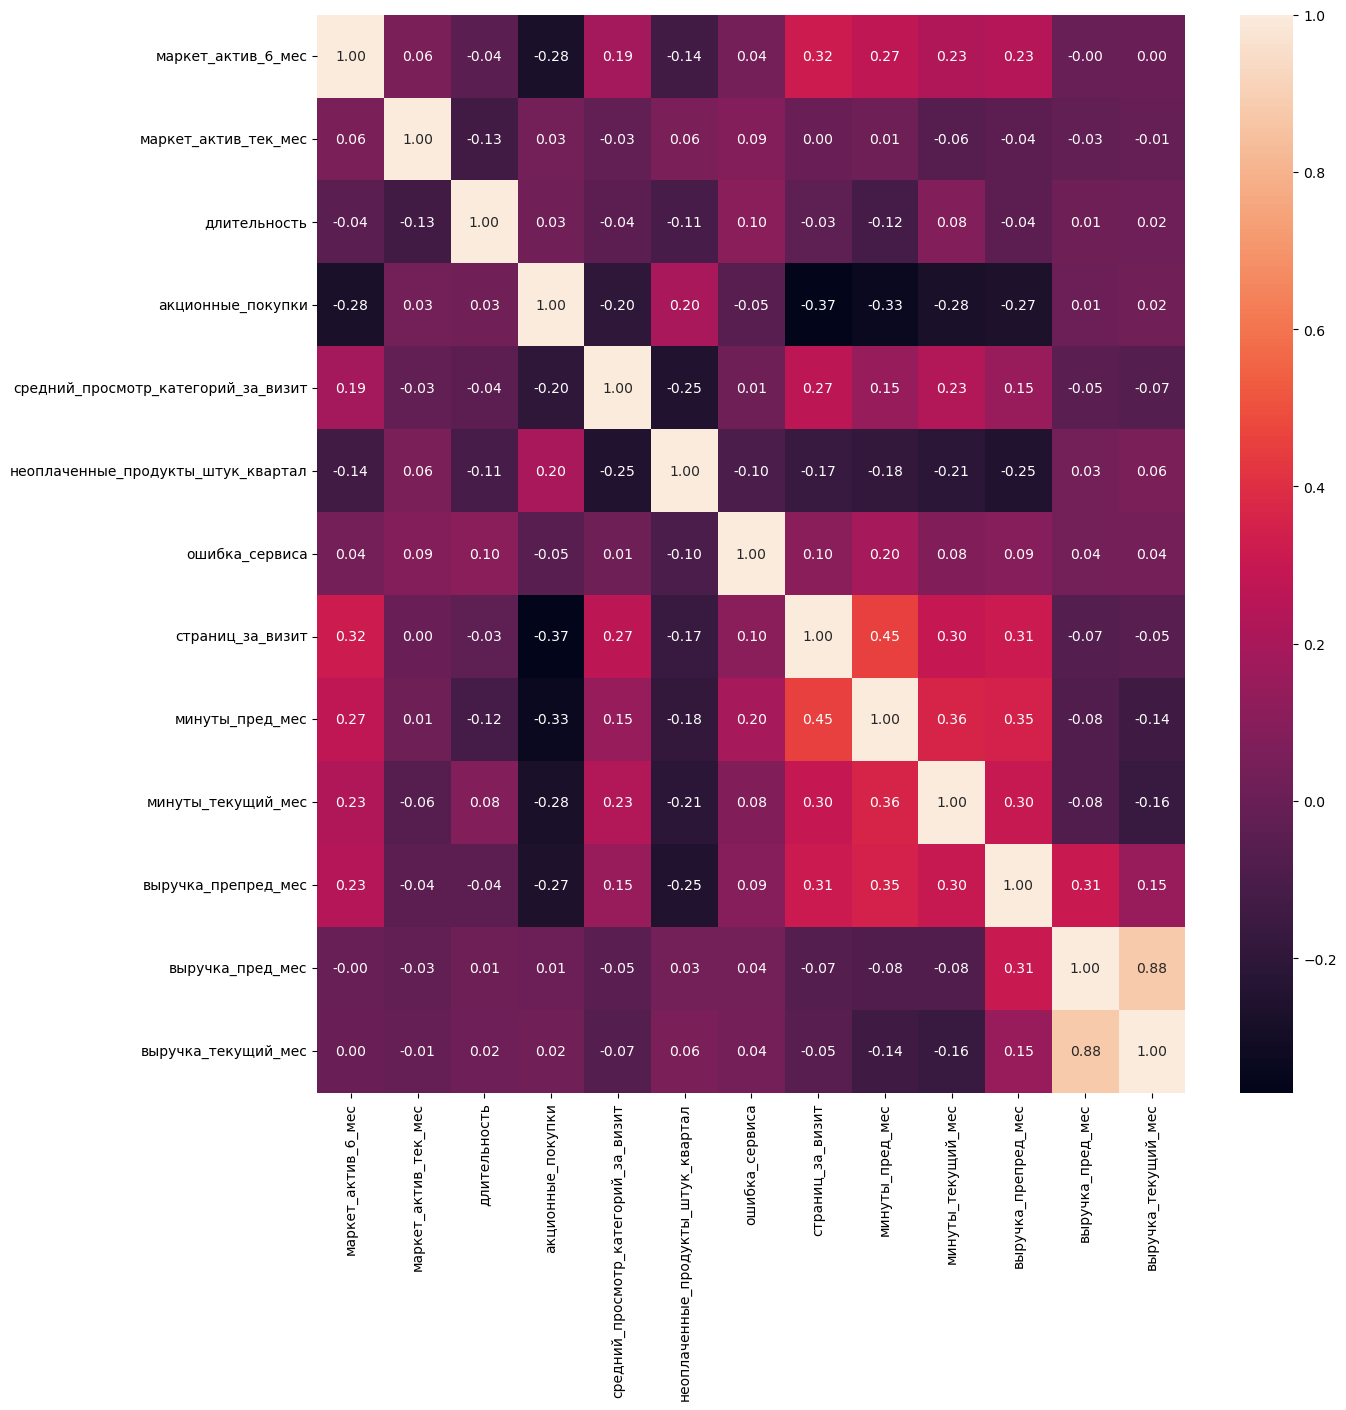

In [40]:
plt.figure(figsize = (14,14))
sns.heatmap(market_united_num.corr(method = 'spearman'), annot=True, fmt='.2f') 

Видим высокую связь (88%) между признаками выручки за текущий и предыдущий месяц. На предыдущем этапе анализа уже отмечалось, что значения выручки за эти периоды близки. Возможно, нужно булет удалить один из признаков для улучшения качества работы модели.

Для определения зависимости между количественными и категориальными признаками используем коэффициент корреляции Фи.

In [41]:
market_united_phik = market_united[['покупательская активность', 'тип сервиса', 'разрешить сообщать',
                                    'популярная_категория',
                                    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',\
                                   'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
                                   'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',\
                                   'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',\
                                   'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес']]

corr_matrix_market_united = market_united_phik.phik_matrix(interval_cols = ['маркет_актив_6_мес', \
                                   'маркет_актив_тек_мес', 'длительность',\
                                   'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
                                   'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',\
                                   'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',\
                                   'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес'],
                                    ) 
display(corr_matrix_market_united)

,покупательская активность,тип сервиса,разрешить сообщать,популярная_категория,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_препред_мес,выручка_пред_мес,выручка_текущий_мес
покупательская активность,1.000000,0.129940,0.000000,0.299717,0.544831,0.000000,0.099901,0.506276,0.539607,0.505655,0.224154,0.749888,0.685138,0.576770,0.497393,0.224638,0.197213
тип сервиса,0.129940,1.000000,0.289965,0.070809,0.089911,0.045258,0.401411,0.030010,0.185391,0.120027,0.079515,0.102594,0.131814,0.000000,0.069704,0.000000,0.124216
разрешить сообщать,0.000000,0.289965,1.000000,0.073684,0.000000,0.052618,0.253831,0.012198,0.070359,0.195982,0.021839,0.042134,0.038387,0.000000,0.000000,0.080842,0.060907
популярная_категория,0.299717,0.070809,0.073684,1.000000,0.150386,0.136243,0.000000,0.122385,0.226116,0.248620,0.000000,0.160300,0.195233,0.089883,0.043528,0.252097,0.237240
маркет_актив_6_мес,0.544831,0.089911,0.000000,0.150386,1.000000,0.079854,0.000000,0.279553,0.206788,0.289421,0.142401,0.396769,0.363950,0.330601,0.315331,0.155476,0.039795
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.136243,0.079854,1.000000,0.174233,0.000000,0.246633,0.144203,0.116946,0.000000,0.107945,0.061410,0.000000,0.051824,0.000000
длительность,0.099901,0.401411,0.253831,0.000000,0.000000,0.174233,1.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.026448,0.101481,0.113200,0.125572,0.147048
акционные_покупки,0.506276,0.030010,0.012198,0.122385,0.279553,0.000000,0.000000,1.000000,0.199180,0.237962,0.000000,0.311418,0.262324,0.250558,0.226381,0.060733,0.071094
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.226116,0.206788,0.246633,0.186795,0.199180,1.000000,0.325578,0.070315,0.262271,0.159837,0.182568,0.176828,0.098440,0.092597
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.248620,0.289421,0.144203,0.192611,0.237962,0.325578,1.000000,0.032907,0.363760,0.256632,0.232383,0.261016,0.249171,0.230022


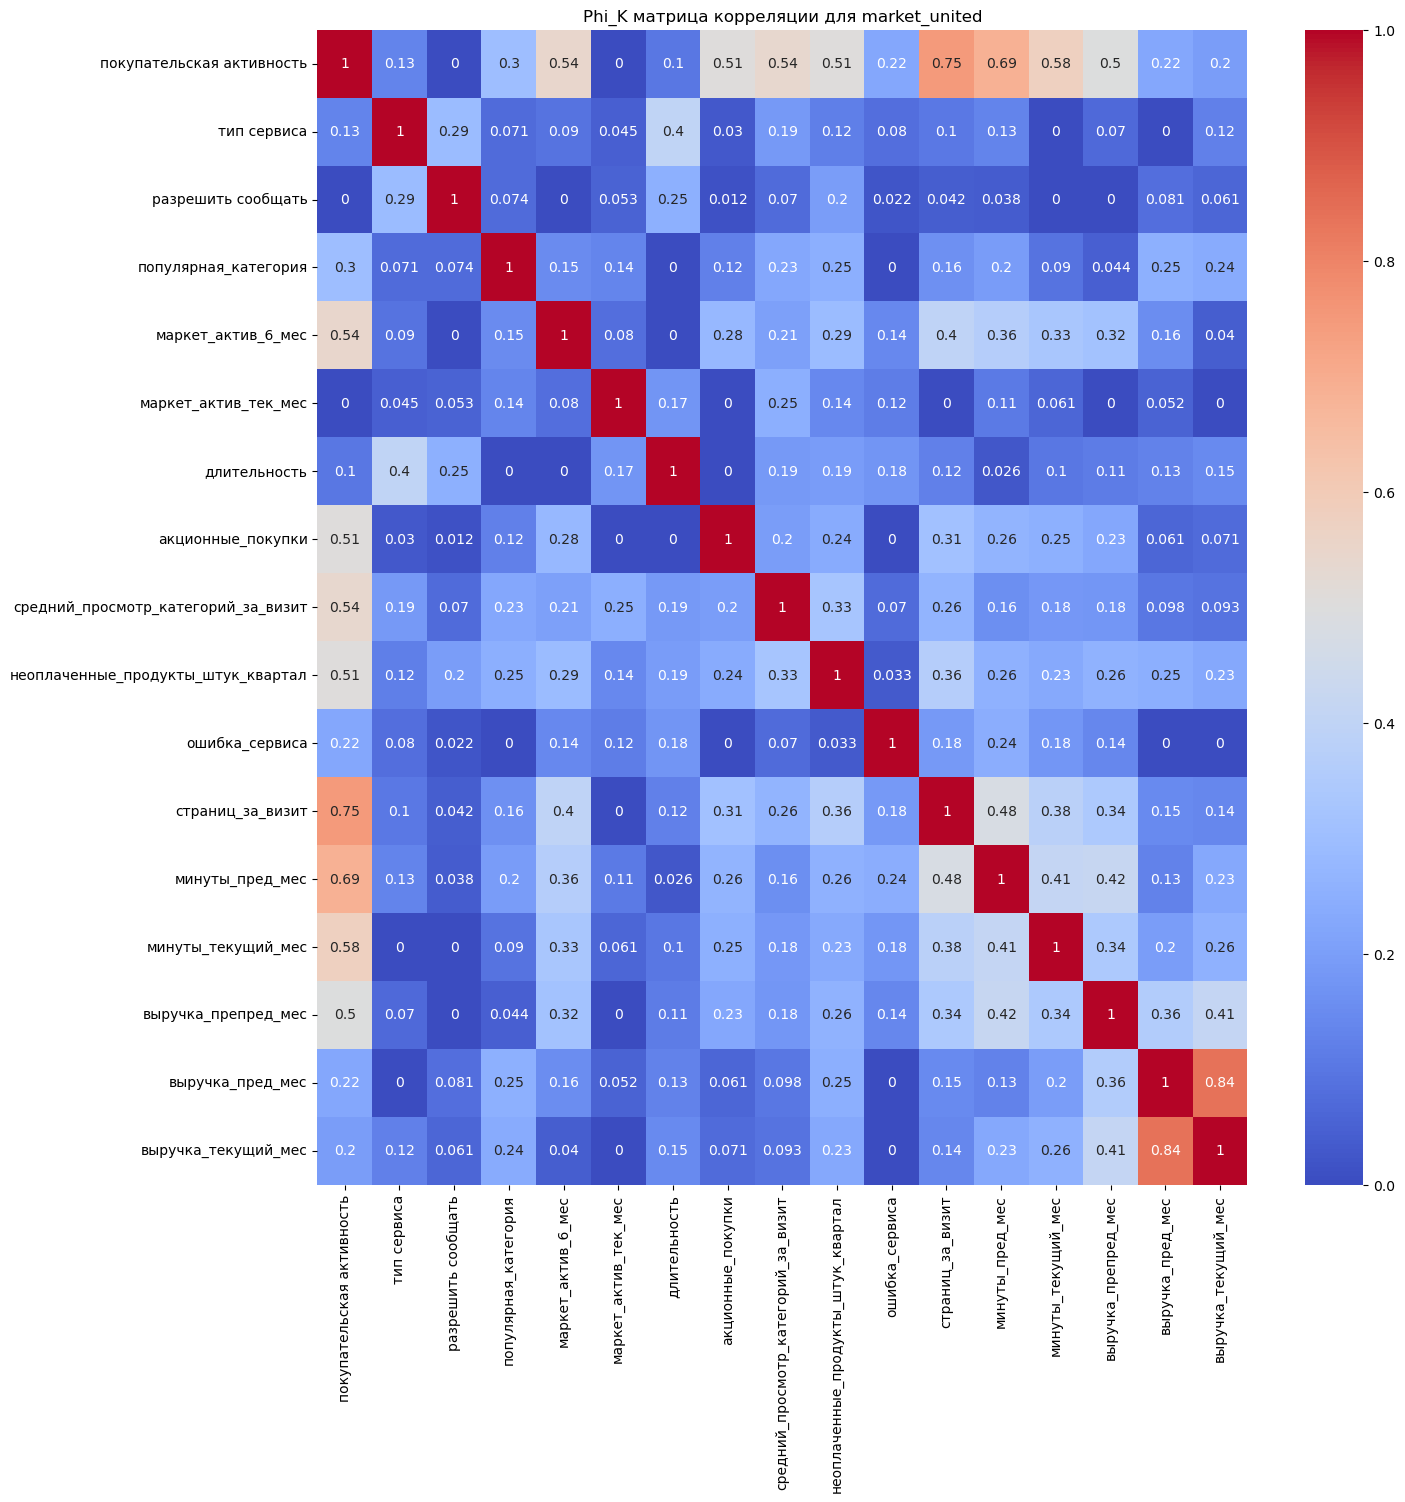

In [42]:
# Визуализация матрицы корреляции матрицы phik

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_market_united, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для market_united')
plt.show()

Высокая корреляция с целевым показателем наблюдается у двух признаков: "Число просмотренных страниц за визит" (75%) и "Время нахождения на сайте в предыдущем месяце, минуты" (69%). Чуть ниже корреляция с показателем "Время нахождения на сайте в текущем месяце, минуты" (58%).
Заметная, но не высокая корреляция с целевым показателем покупательской активности у признаков "Выручка в препредыдущем месяце" (50%), "Неоплаченные продукты" (50%), "Средний просмотр категорий за визит" (54%), "Акционные покупки" (51%).
Не понятно, почему есть корреляция (50%) между показатлем "Маркет_актив_ 6 мес" (среднемесячное число взаимодействий с покупателем), а корреляция с показателем "маркет_актив текущий месяц" (число взаимодействий с покупателем в текущем месяце) отсутствует.
Та же ситуация с показателем выручки: у целевого показателя заметная корреляция с выручкой за препредыдущий месяц (50%), а корреляция с показателем выручки за текущий месяц нулевая.

Разделим исходный датасет на два по значению покупательской активности: в одном датасете будут клиенты, у которых покупательская активность снизилась, в другом - у которых осталась на прежнем уровне.

In [43]:
market_united_phik_stable = market_united_phik[market_united_phik['покупательская активность'] == 'Прежний уровень']

In [44]:
market_united_phik_decline = market_united_phik[market_united_phik['покупательская активность'] == 'Снизилась']

Построим матрицу корреляций Фи по клиентам чья активность снизилась.

In [45]:
corr_matrix_market_decline = market_united_phik_decline.phik_matrix(interval_cols = ['маркет_актив_6_мес', \
                                   'маркет_актив_тек_мес', 'длительность',\
                                   'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
                                   'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',\
                                   'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',\
                                   'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес'],
                                    )
display(corr_matrix_market_decline)

C:\Users\babay\anaconda3\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable покупательская активность for analysis 1. Dropping this column
  warnings.warn(


,тип сервиса,разрешить сообщать,популярная_категория,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_препред_мес,выручка_пред_мес,выручка_текущий_мес
тип сервиса,1.000000,0.270449,0.104317,0.129115,0.000000,0.400477,0.056124,0.226420,0.160224,0.150046,0.170363,0.178948,0.000000,0.221292,0.000000,0.030954
разрешить сообщать,0.270449,1.000000,0.215637,0.000000,0.032900,0.238934,0.000000,0.000000,0.177690,0.000000,0.070531,0.000000,0.000000,0.079843,0.167949,0.000000
популярная_категория,0.104317,0.215637,1.000000,0.183761,0.187794,0.000000,0.163983,0.062967,0.294511,0.056143,0.104784,0.259658,0.120672,0.000000,0.276140,0.255976
маркет_актив_6_мес,0.129115,0.000000,0.183761,1.000000,0.223856,0.269087,0.220180,0.212394,0.198051,0.086239,0.435827,0.370440,0.304060,0.359179,0.150997,0.184549
маркет_актив_тек_мес,0.000000,0.032900,0.187794,0.223856,1.000000,0.139678,0.000000,0.357604,0.186687,0.166855,0.175500,0.234435,0.182274,0.000000,0.000000,0.094066
длительность,0.400477,0.238934,0.000000,0.269087,0.139678,1.000000,0.000000,0.323279,0.270956,0.165554,0.199113,0.000000,0.000000,0.225174,0.225483,0.181397
акционные_покупки,0.056124,0.000000,0.163983,0.220180,0.000000,0.000000,1.000000,0.130824,0.151004,0.000000,0.317488,0.324229,0.303303,0.188927,0.000000,0.102631
средний_просмотр_категорий_за_визит,0.226420,0.000000,0.062967,0.212394,0.357604,0.323279,0.130824,1.000000,0.301348,0.112164,0.254174,0.170606,0.123741,0.235071,0.000000,0.000000
неоплаченные_продукты_штук_квартал,0.160224,0.177690,0.294511,0.198051,0.186687,0.270956,0.151004,0.301348,1.000000,0.063936,0.267396,0.299879,0.222317,0.000000,0.245787,0.204223
ошибка_сервиса,0.150046,0.000000,0.056143,0.086239,0.166855,0.165554,0.000000,0.112164,0.063936,1.000000,0.143420,0.120347,0.130706,0.139048,0.093930,0.038763


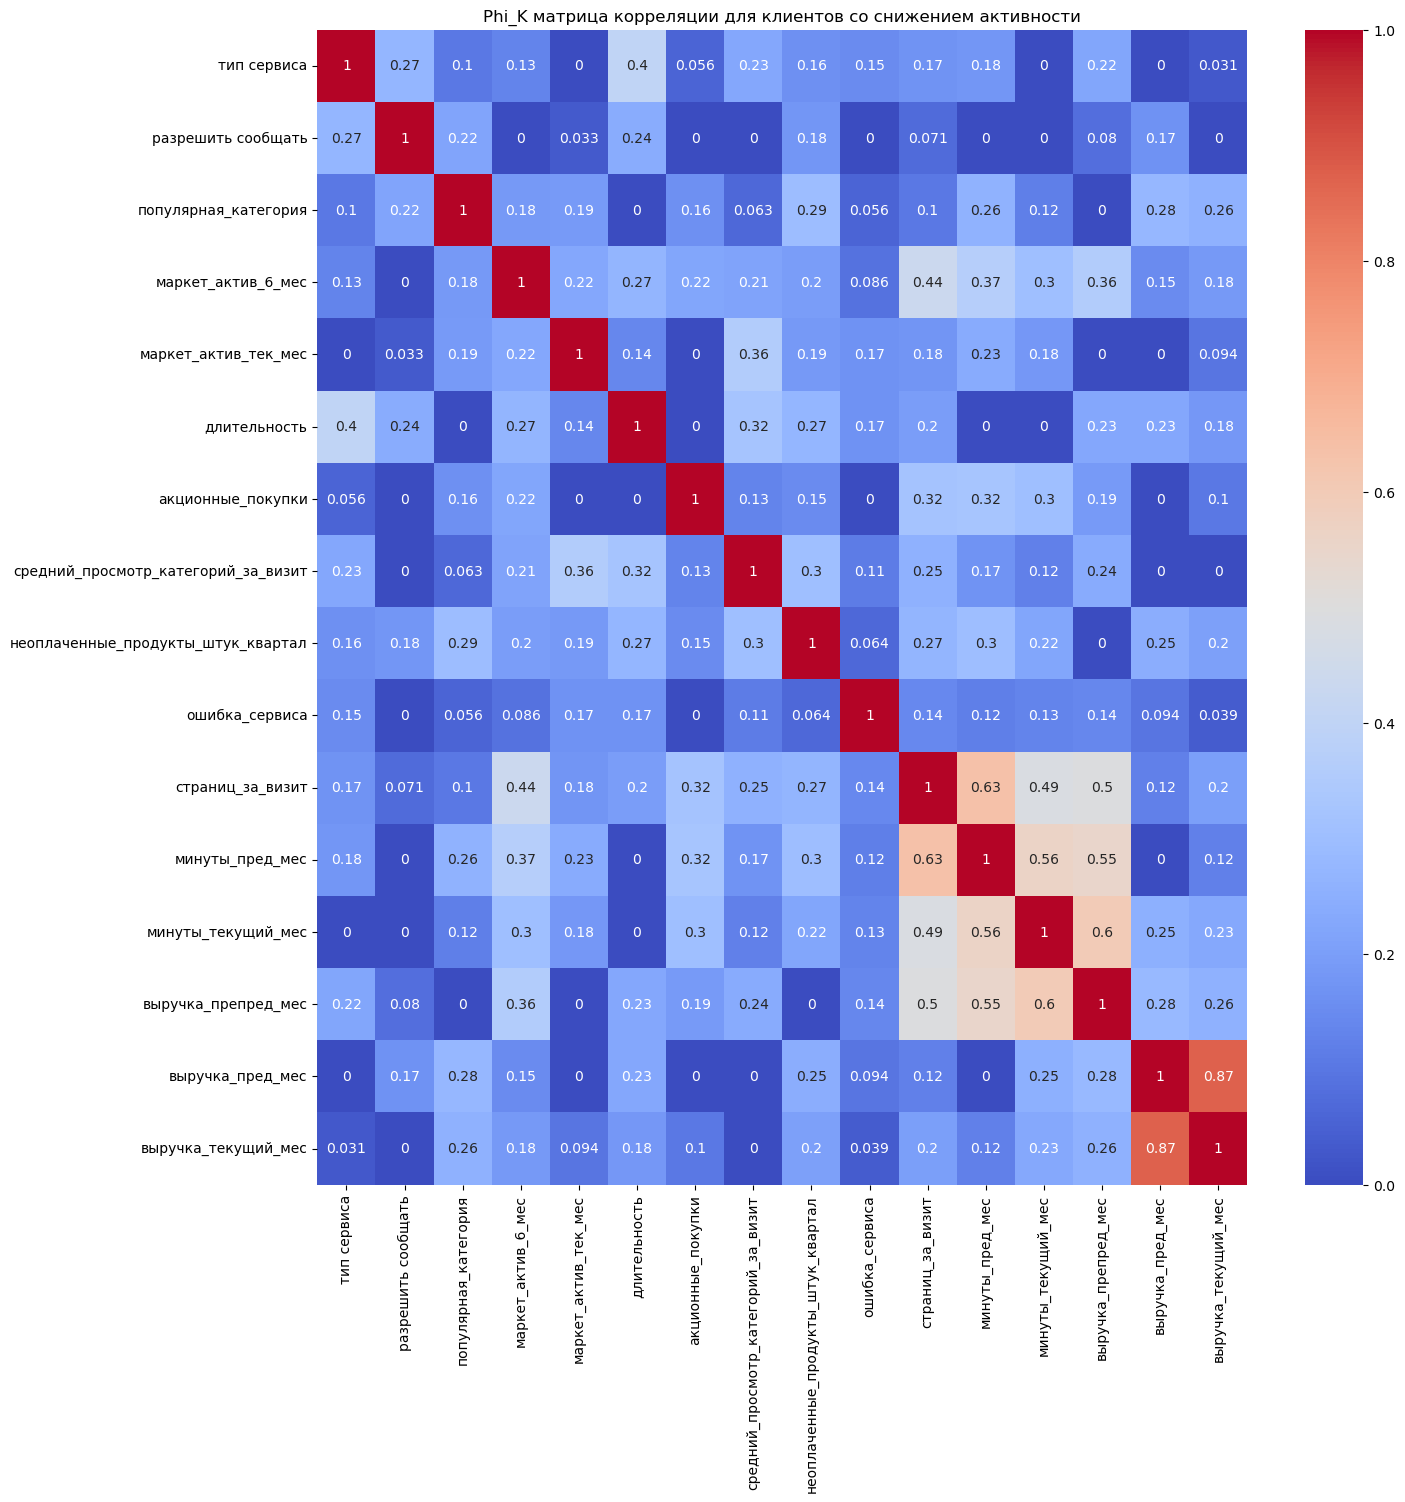

In [46]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_market_decline, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для клиентов со снижением активности')
plt.show()

Мультиколлинеарности нет, есть ощутимая корреляция между показателем типа сервиса и выручкой в предыдущем месяце (84%), но не критично для того, чтобы удалять один из признаков.

Построим матрицу корреляции для клиентов с прежней активностью.

In [47]:
corr_matrix_market_stable = market_united_phik_stable.phik_matrix(interval_cols = ['маркет_актив_6_мес', \
                                   'маркет_актив_тек_мес', 'длительность',\
                                   'акционные_покупки', 'средний_просмотр_категорий_за_визит',\
                                   'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',\
                                   'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',\
                                   'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес'],
                                    )
display(corr_matrix_market_stable)

C:\Users\babay\anaconda3\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable покупательская активность for analysis 1. Dropping this column
  warnings.warn(


,тип сервиса,разрешить сообщать,популярная_категория,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_препред_мес,выручка_пред_мес,выручка_текущий_мес
тип сервиса,1.000000,0.293044,0.000000,0.000000,0.056050,0.395860,0.000000,0.133683,0.069945,0.000000,0.103943,0.000000,0.172217,0.000000,0.158301,0.115690
разрешить сообщать,0.293044,1.000000,0.000000,0.038701,0.067547,0.234514,0.063418,0.115093,0.170493,0.024660,0.000000,0.000000,0.000000,0.030468,0.000000,0.000000
популярная_категория,0.000000,0.000000,1.000000,0.126105,0.254070,0.018976,0.000000,0.234219,0.239175,0.000000,0.155694,0.146152,0.036022,0.000000,0.230392,0.363295
маркет_актив_6_мес,0.000000,0.038701,0.126105,1.000000,0.159854,0.000000,0.101504,0.000000,0.000000,0.138019,0.000000,0.000000,0.081394,0.192076,0.351770,0.040376
маркет_актив_тек_мес,0.056050,0.067547,0.254070,0.159854,1.000000,0.157241,0.056968,0.205234,0.147220,0.146153,0.000000,0.000000,0.073355,0.000000,0.000000,0.000000
длительность,0.395860,0.234514,0.018976,0.000000,0.157241,1.000000,0.000000,0.028660,0.025546,0.224556,0.000000,0.000000,0.187399,0.002658,0.000000,0.227522
акционные_покупки,0.000000,0.063418,0.000000,0.101504,0.056968,0.000000,1.000000,0.000000,0.032153,0.030268,0.000000,0.000000,0.000000,0.000000,0.000000,0.073573
средний_просмотр_категорий_за_визит,0.133683,0.115093,0.234219,0.000000,0.205234,0.028660,0.000000,1.000000,0.207764,0.081617,0.055496,0.122645,0.019083,0.152694,0.000000,0.050208
неоплаченные_продукты_штук_квартал,0.069945,0.170493,0.239175,0.000000,0.147220,0.025546,0.032153,0.207764,1.000000,0.000000,0.047480,0.000000,0.068098,0.121639,0.000000,0.000000
ошибка_сервиса,0.000000,0.024660,0.000000,0.138019,0.146153,0.224556,0.030268,0.081617,0.000000,1.000000,0.000000,0.181558,0.168871,0.126096,0.000000,0.155586


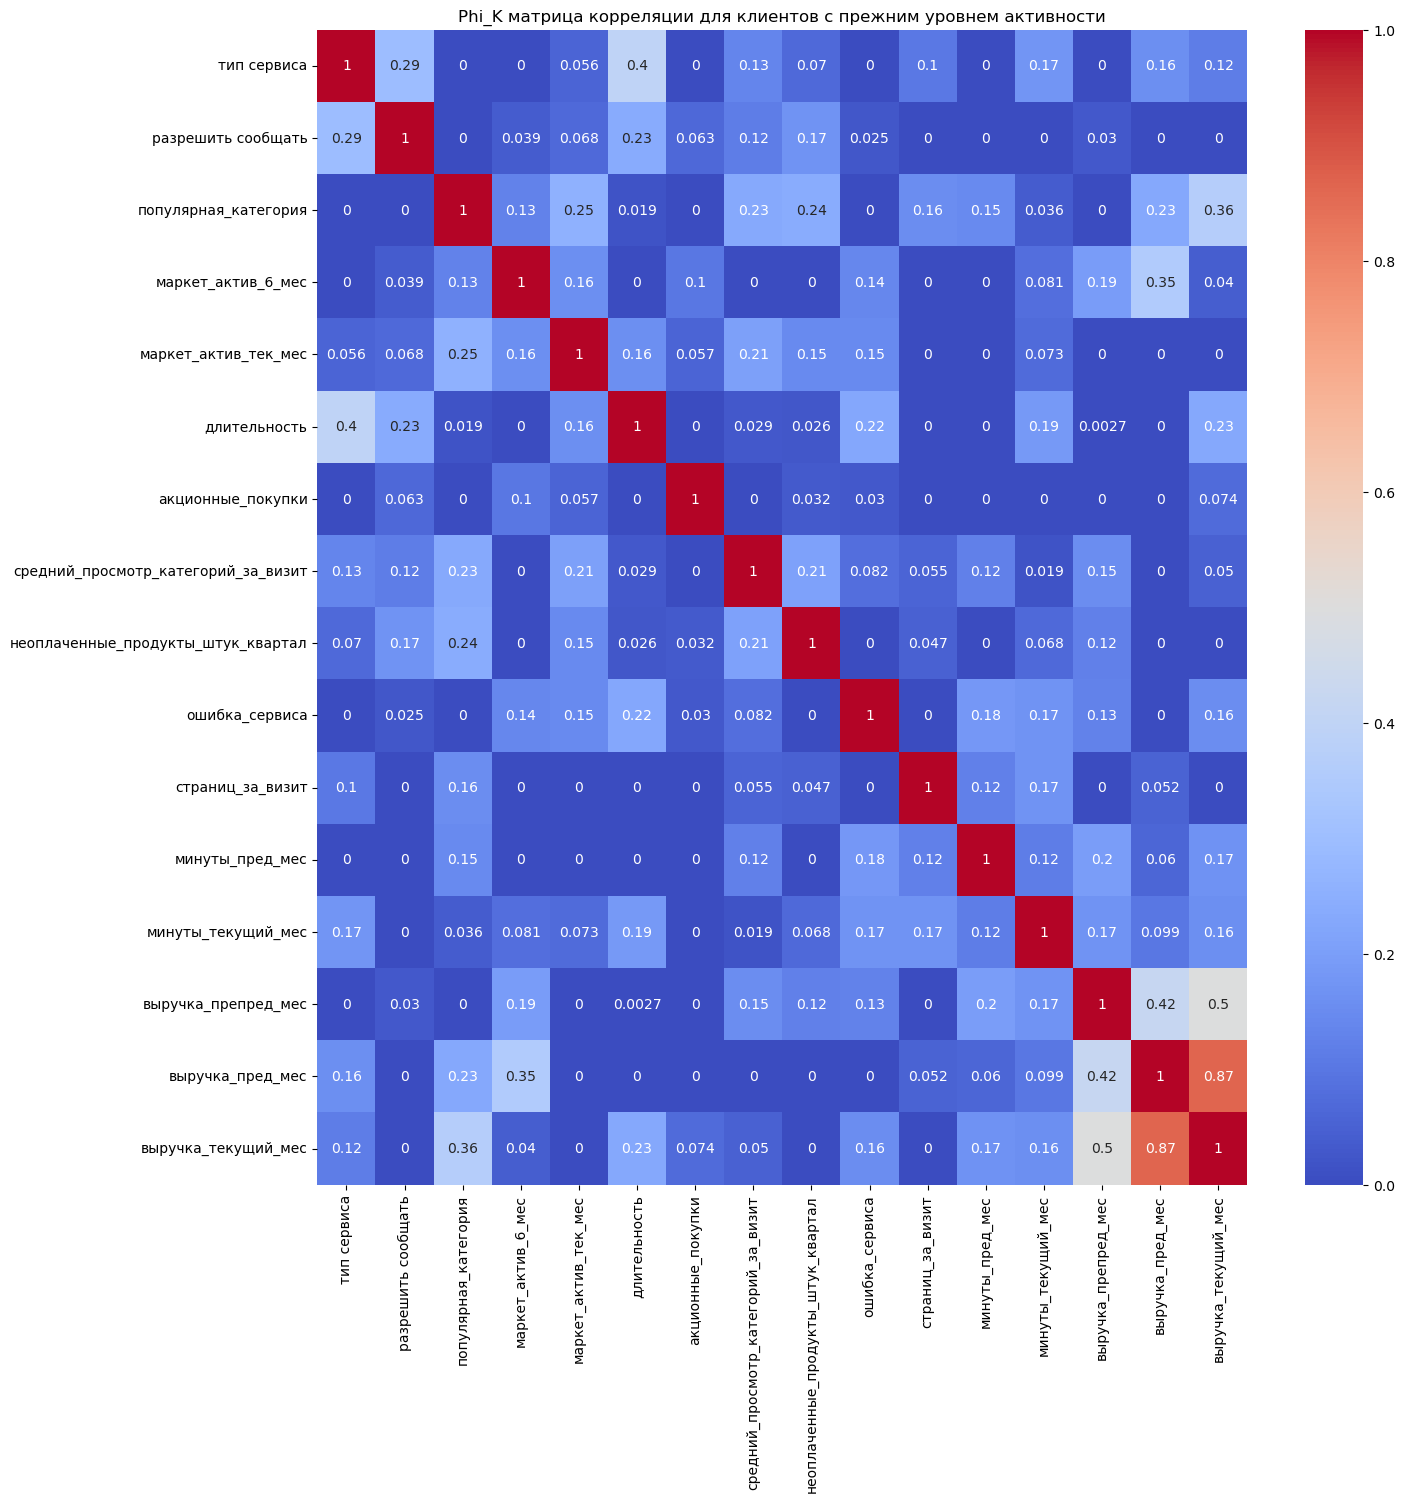

In [48]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_market_stable, annot=True, cmap='coolwarm')
plt.title('Phi_K матрица корреляции для клиентов с прежним уровнем активности')
plt.show()

***Вывод*** по итогам корреляционного анализа:

Мультиколлинеарности между признаками не выявлено, максимальная корреляция с целевым признаком у показателей числа просмотренных за визит страниц (75%) и времени, проведенного на сайте (69%).

## Шаг 6. Использование пайплайнов

Определим, какие признаки требуют масштабирования, а какие - кодирования. И какими кодировщиками будем кодировать разные категориальные признаки.

Перечислим особенности данных:

**1)** Два признака: "Популярная категория", "Разрешить сообщать" — нужно кодировать с помощью OneHotEncoder, т к "Разрешить сообщать" - это бинарный признак, а "Популярная категория" нельзя отнести к ранговым (OrdinalEncoder использовать нельзя).

**2)** Один признак "Тип сервиса" нужно кодировать с помощью OrdinalEncoder. Это ранговый признак, значения которого можно расставить в порядке возрастания значимости: "стандарт" - менее значимый, "премиум" - более значимый.

**3)** В признаках, закодированных этими методами, встречаются пропуски. Заполним их самым часто встречающимся значением с помощью SimpleImputer. Назовём этот шаг simpleImputer_ohe.

**4)** Количественные признаки:
***'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
'акционные_покупки', 'средний_просмотр_категорий_за_визит',
'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
'страниц_за_визит', 'минуты_пред_мес', 'минуты_текущий_мес',
'выручка_препред_мес', 'выручка_пред_мес', 'выручка_текущий_мес'***
                                   нужно масштабировать.

Разделим данные на тренировочную и тестовую выборки.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    market_united.drop(['покупательская активность'], axis=1),
    market_united['покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_united['покупательская активность']
)


Закодируем целевой признак с помощью LabelEncoder.

In [50]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

In [51]:
print(label_encoder.classes_)


['Прежний уровень' 'Снизилась']


Определим перечень категориальных и количественных столбцов. Категориальные признаки нужно разделить на те, которые будем кодировать OneHotEncoder и OrdinalEncoder.
С помощью OneHotEncoder будем кодировать признак "разрешить сообщать", т к это бинарный признак, и "популярная категория" - этот признак не ранговый (нельзя выстроить значения в порядке возрастания значимости), и не правильно будет кодировать его с помощью OrdinalEncoder.
Признак "тип сервиса" можно отнести к ранговым переменным, т к его значения можно выстроить в порядке увеличения: "стандарт" (признак ниже рангом) и "премиум" (признак выше рангом).

In [52]:
ohe_columns = ['разрешить сообщать', 'популярная_категория']

ord_columns = ['тип сервиса']

num_columns = [    
    'длительность', 'средний_просмотр_категорий_за_визит',\
                         'маркет_актив_тек_мес', 'ошибка_сервиса', 'страниц_за_визит',\
                         'минуты_пред_мес', 'минуты_текущий_мес', 'выручка_препред_мес',\
                         'выручка_пред_мес', 'выручка_текущий_мес', 'неоплаченные_продукты_штук_квартал',\
                         'акционные_покупки', 'маркет_актив_6_мес']


Добавляем ***OHE-кодирование*** в Пайплайн
 
***1)*** Если в данных есть пропуски, заполним их самым часто встречающимся значением с помощью SimpleImputer. Назовём этот шаг simpleImputer_ohe.

***2)*** Кодируем данные с помощью OneHotEncoder. Назовём это шаг ohe.

***3)*** Объединим шаги в пайплайн и назовём его ohe_pipe.

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

In [54]:
print(market_united['тип сервиса'].unique())


['премиум' 'стандарт']


Добавляем ***Ordinal-кодирование*** в пайплайн.

***1)*** simpleImputer_before_ord: Заполним пропуски самым часто встречающимся значением с помощью SimpleImputer. 

***2)*** ord: Проводим Ordinal-кодирование с помощью OrdinalEncoder. 

***3)*** simpleImputer_after_ord: Заполним пропуски, которые появляются после Ordinal-кодирования. 

***4)*** ord_pipe: Объединим все действия в пайплайн.

In [55]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [['стандарт', 'премиум']],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Применим инструмент ColumnTransformer для объединения всех операций по подготовке данных.


In [56]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Пайплайн подготовки данных создан. Присоединим к нему шаг с моделированием — будем использовать модель DecisionTreeClassifier. Итоговый пайплайн назовём pipe_final. Он включает шаги:

Подготовка данных — шаг preprocessor.
Инициализация модели DecisionTreeClassifier — шаг models.

In [57]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Зададим метод масштабирования как гиперпараметр, чтобы перебирались методы StandardScaler(), RobustScaler() и MinMaxScaler(). Для автоматического подбора гиперпараметров будем использовать инструменты RandomizedSearch и GridSearchCV.

В словаре укажем, какие варианты масштабирования собираемся перебрать: StandardScaler(), RobustScaler(), MinMaxScaler() и вариант без масштабирования.

Зададим в качестве гиперпараметра модели, которые хотим использовать: DecisionTreeClassifier(), SVС(), KNeighborsClassifier() и LogisticRegression().

In [58]:
param_rs = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6), 
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression
        (
         random_state=RANDOM_STATE,
         solver='liblinear', 
         penalty='l1'
        )
                  ],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    # словарь для модели SVC() с poly ядром
    {
        'models': [SVC(random_state = RANDOM_STATE, probability = True, kernel = 'poly')],
        'models__degree': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели SVC() с ядром  linear и rbf
    {
        'models': [SVC(random_state = RANDOM_STATE, probability = True)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

Для этой задачи лучше использовать метрику recall, потому что в этом случае важно не пропустить тех клиентов, у которых снизилась активность. В данной задаче нужно минимизировать ошибки 2 рода: ошибка классифицировать клиента с меткой класса 1 ("активность снизилась") за клиента с меткой класса 0 ("Активность сохранилась на прежнем уровне").
 Метрика recall измеряет, смогла ли модель классификации присвоить класс 1 ("активность снизилась") всем объектам этого класса. Чем выше recall, тем больше прогнозов Positive модель смогла дать верно. 

В данном случае не критично классифицировать клиента класса 0 (активность сохранилась) за клиента класса 1 (активность снизилась), лишний раз отправив ему предложение для повышения активности. Но плохо, если пропустить клиента со сниженной активностью (если модель ошибется, выдав его за клиента с меткой 0) и не отправить ему предложение.

Поэтому выбираем метрику recall.
Запустим автоматический подбор с помощью RandomizedSearchCV: 

In [59]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_rs, 
    scoring = 'recall',
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_encoded) 

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['разрешить '
                                                                                'сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer...
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='recall')

In [60]:
print('Метрика recall для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика recall для лучшей модели:
 0.7520360360360361

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['разрешить сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImpute

Проверим работу модели на тестовой выборке

In [61]:
y_test_pred = randomized_search.predict(X_test)
print('Метрика recall на тестовой выборке:', recall_score(y_test_encoded, y_test_pred))

Метрика recall на тестовой выборке: 0.8130081300813008


По итогам подбора RandomizedSearch получили лучшую модель LogisticRegression, лучший скейлер StandardScaler и метрику recall для лучшей модели 75,2%. На тестовой выборке показатель сеще выше - 81,3%, достаточно высокий результат. 

Запустим автоматический подбор с помощью GridSearchCV:

Создадим метрику, устойчивую к операции деления на ноль:

In [62]:
def safe_recall(y_test_encoded, y_test_pred):
        return recall_score(y_test_encoded, y_test_pred, zero_division= 0)

safe_recall_scorer = make_scorer(safe_recall)

In [63]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_rs, 
    cv=5, 
    scoring = safe_recall_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train_encoded) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['разрешить '
                                                                          'сообщать',
                                                                          'популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_...
                                         random_state=42)],
                          'models__degree': range(2, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__kernel': ['linear', 'rbf'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(safe_recall, response_method='predict'))

In [64]:
print('Метрика recall для лучшей модели:\n', grid.best_score_)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_) 

Метрика recall для лучшей модели:
 0.7601081081081082
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['разрешить сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer

In [65]:
y_test_pred_grid = grid.predict(X_test)
print('Метрика recall на тестовой выборке:', recall_score(y_test_encoded, y_test_pred_grid))

Метрика recall на тестовой выборке: 0.8455284552845529


По итогам подбора GridSearch получили лучшую модель SVC с полиномиальным ядром степени 5, лучший скейлер StandardScaler и метрику Recall для лучшей модели 76%. На тестовой выборке модель показала высокий recall - 84,55%. Т е модель не пропускает 84,55% клиентов, которые в ближайшее время покажут снижение активности.

Будем использовать результаты GridSearch, т к это более точный инструмент, перебирающий все возможные значения. 


 ## Шаг 7. Анализ важности признаков

Оценим важность признаков для лучшей модели и построим графики важности признаков с помощью метода SHAP. 

  0%|          | 0/324 [00:00<?, ?it/s]

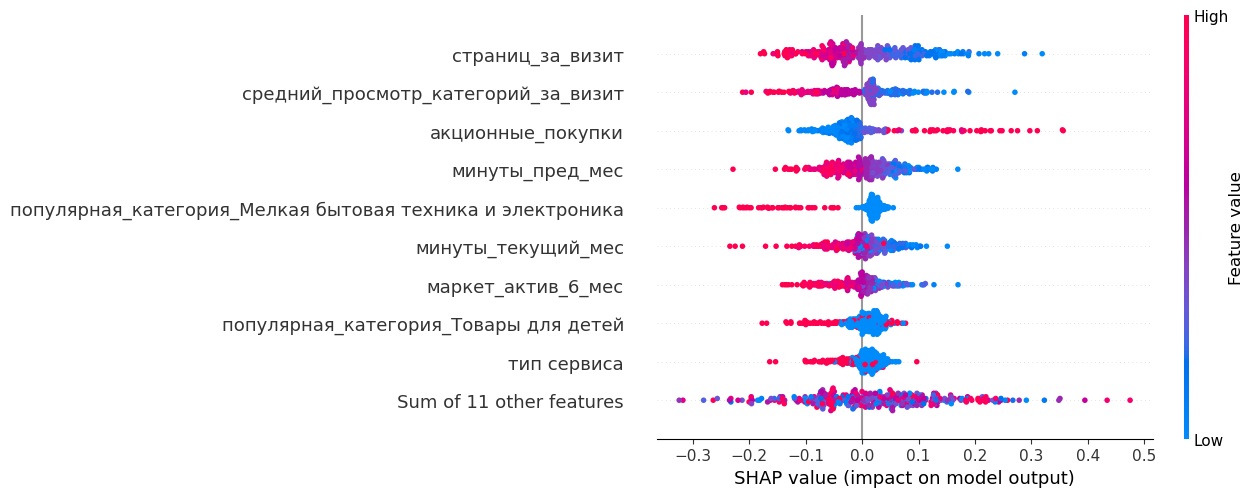

In [66]:
preprocessor = grid.best_estimator_['preprocessor']
cat_ohe = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features = ohe_columns)
cat_ord = preprocessor.named_transformers_['ord'].get_feature_names_out(input_features = ord_columns)
nums = preprocessor.named_transformers_['num'].get_feature_names_out(input_features = num_columns)

feature_names = np.concatenate([cat_ohe, cat_ord, nums])


X_train_encoded = preprocessor.fit_transform(X_train)
model = grid.best_estimator_.named_steps['models']
X_train_encoded.shape, model

X_shap = shap.kmeans(X_train_encoded, 19)
explainer = shap.KernelExplainer(model.predict_proba, X_shap, feature_names = feature_names)

X_test_shap = preprocessor.transform(X_test)
shap_values = explainer(X_test_shap)
shap.plots.beeswarm(shap_values[:, :, 1])

Чем больше значения признаков "страниц за визит", "средний просмотр категорий" и "минуты текущий месяц", "минуты предыдущий месяц", тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0 (активность сохранилась на прежнем уровне).

Чем больше значение признаков "акционые покупки", тем выше SHAP-значения. Если у наблюдений высокие значения признаков "акционные покупки" и ""неоплаченные продукты", то у них высокая вероятность принадлежности к классу 1 (активность снизилась).

По графику shap.beeswarm видим, что максимальное влияние на рост вероятности снижения активности оказывают признаки "страниц за визит", "средний просмотр категорий", "минуты текущий месяц",  "акционые покупки".

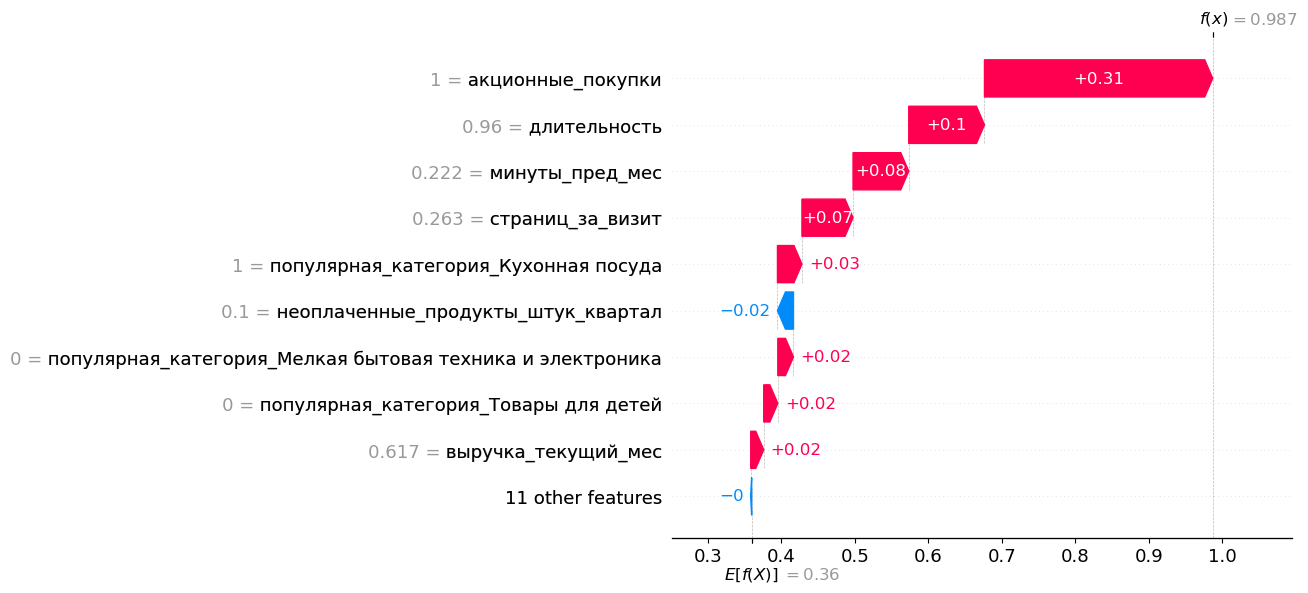

In [67]:
shap.plots.waterfall(shap_values[10, :, 1]) 

Сильнее всего на его классификацию данного наблюдения в датасете влияет признак "акционные покупки": он перетягивает предсказание в сторону класса 1 (активность снизилась). 

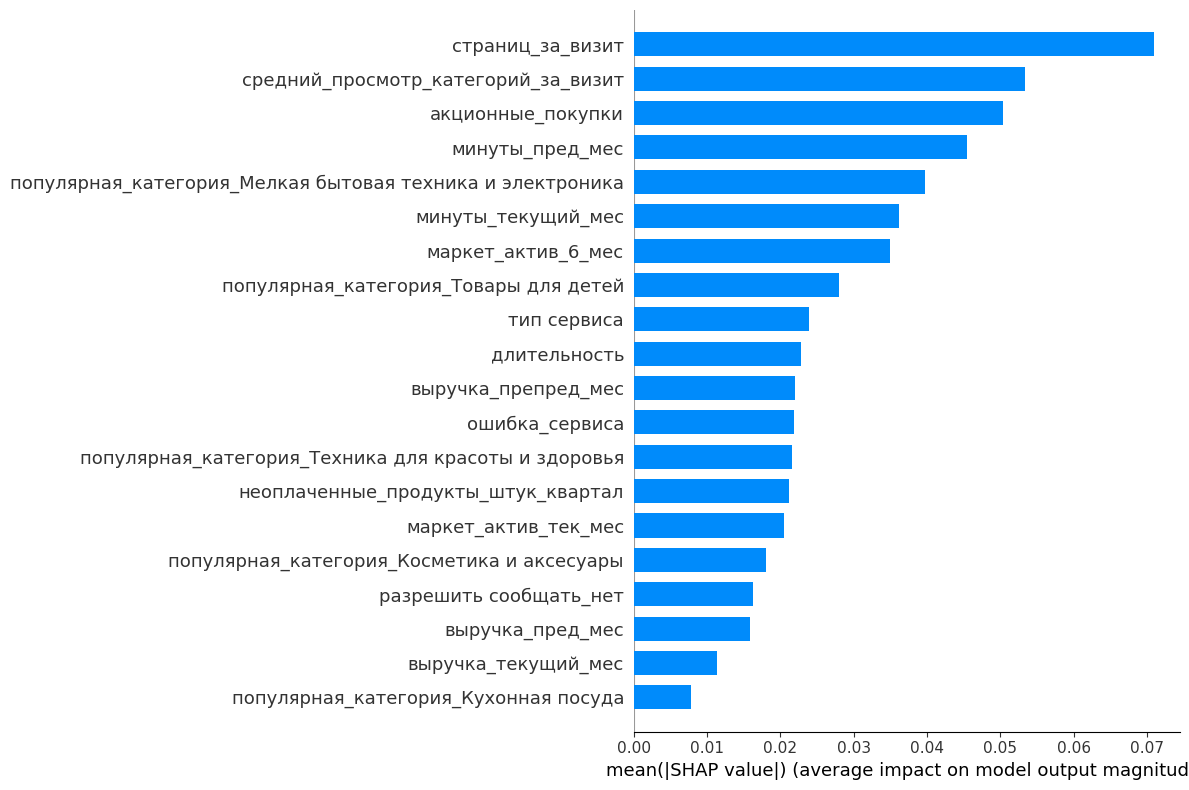

In [68]:
shap.summary_plot(shap_values[:, :, 1], plot_type = 'bar', plot_size = (12, 8)) 

На диаграмме видим общий вклад признаков в прогнозы модели. Так же, как и награфике beeswarm видим, что максимальные SHAP-значения (и максимальное влияние на целевой признак) оказывают признаки "страниц за визит", "средний просмотр категорий", "минуты предыдущий месяц", "акционые покупки".

Для принятия решения по способам удержания активности клиентов имеет смысл анализировать признаки, имеющие максимальное влияние на целевой, и при выделении сегментов на следующем шаге учитывать эти признаки.

## Шаг 8. Сегментация покупателей


Выведем значения целевого признака.

In [69]:
pd.DataFrame(y_train_encoded, y_train, columns=['LabelEncoder']) 

,LabelEncoder
покупательская активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
...,...
Прежний уровень,0
Прежний уровень,0
Снизилась,1


Еще раз убедились, что метка 0 соответствует значению признака покупательской активности "прежний уровень".
А  метка 1 означает, что покупательская активность снизилась.

Посчитаем вероятности принадлежности признака "покупательская аквтиность" к значению "снизилась".

In [70]:
y_test_proba = grid.predict_proba(X_test)[:,1]

Оформими таблицу со значениями predict_proba и соответсвующими этим строкам id.

In [71]:
data_prognose = pd.DataFrame(zip(y_test_proba),
             columns = ['probability_decline'])

In [72]:
display(data_prognose.head())

,probability_decline
0,0.047875
1,0.867045
2,0.381657
3,0.882120
4,0.709381


In [73]:
id_series = pd.Series(X_test.index)
id_df = id_series.to_frame(name='id')
id_df.head()

,id
0,216161
1,215654
2,216307
3,215501
4,215934


In [74]:
data_prognose = pd.concat([id_df, data_prognose], axis = 1)

In [75]:
display(data_prognose.head())


,id,probability_decline
0,216161,0.047875
1,215654,0.867045
2,216307,0.381657
3,215501,0.882120
4,215934,0.709381


Объединим данные из тестовой выборки с  таблицей прогноза покупательской активности.

In [76]:
X_test_prognose = pd.merge(X_test, data_prognose, on = 'id', how = 'outer')
display(X_test_prognose.head())

,id,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_пред_мес,выручка_препред_мес,выручка_текущий_мес,probability_decline
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,3973.0,4912.0,3289.2,0.047875
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,3548.0,4656.0,4170.7,0.867045
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,5444.0,4565.0,6335.8,0.381657
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,6604.0,4993.0,6758.7,0.882120
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,5090.0,4451.0,5773.8,0.709381


Объединим таблицу прогноза активности с информацией о прибыльности клиентов из файла 'money'.

In [77]:
money.head()

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


Добавим в таблицу с прогнозом покупательской активности информацию о прибыли по этим клиентам. Объединим с таблицей money по признаку 'id'.

In [78]:
X_test_prognose_profit = pd.merge(X_test_prognose, money, on = 'id', how = 'left')
display(X_test_prognose_profit.head())

,id,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_пред_мес,выручка_препред_мес,выручка_текущий_мес,probability_decline,прибыль
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,16,17,3973.0,4912.0,3289.2,0.047875,4.69
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,3548.0,4656.0,4170.7,0.867045,2.75
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,20,11,5444.0,4565.0,6335.8,0.381657,3.16
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,6604.0,4993.0,6758.7,0.882120,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,5090.0,4451.0,5773.8,0.709381,4.40


Прежде чем выделить сегмент, посмотрим диаграммы рассеяния, показывающие зависимость между прибылью от клиента и вероятностью снижения активности.

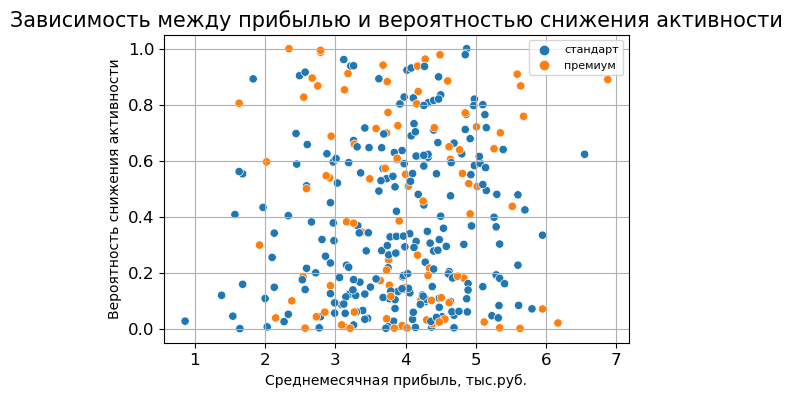

In [84]:
plt.figure(figsize=[6, 4])
plt.title('Зависимость между прибылью и вероятностью снижения активности', fontsize=15)
sns.scatterplot(data = X_test_prognose_profit, x = 'прибыль', y='probability_decline', hue = 'тип сервиса')
plt.xlabel('Среднемесячная прибыль, тыс.руб.', fontsize = 10)
plt.ylabel('Вероятность снижения активности', fontsize = 10)
plt.legend(fontsize = 8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

На диаграмме рассеяния видно, что ощутимой зависимости между показателем прибыли и вероятностью снижения активности клиента нет: достаточно много клиентов с разными значениями прибыли имеют низкую вероятность снижения покупательской активности. ЧУть меньше клиентов, опять же с разными значениями прибыли, имеют высокую вероятность снижения покупательской активности.

Меня интересовало наличие зависимости между тарифом клиента и вероятностью снижения активности. Закономерностей между этими показателями на диаграмме не прослеживается.

По итогам анализа важности признаков мы увидели, что наиболее значимым вкладом в значение целевого признака обладает фактор количества просмотренных страниц за визит. Построим диаграмму рассеяния, чтобы посмотреть зависимость между этим фактором и вероятностью снижения активности.

На графике выделим разными цветами группы клиентов, которые разрешили и не разрешили сообщать об акциях и предложениях.

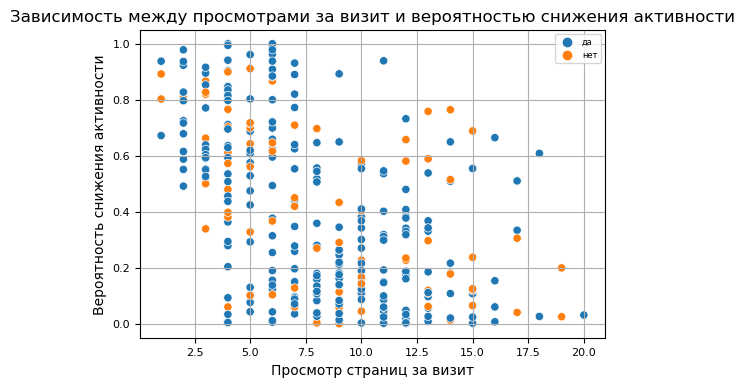

In [89]:
plt.figure(figsize=[6, 4])
plt.title('Зависимость между просмотрами за визит и вероятностью снижения активности', fontsize=12)
sns.scatterplot(data = X_test_prognose_profit, x = 'страниц_за_визит', y='probability_decline', hue = 'разрешить сообщать')
plt.xlabel('Просмотр страниц за визит', fontsize = 10)
plt.ylabel('Вероятность снижения активности', fontsize = 10)
plt.legend(fontsize = 6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

Видим высокую вероятность снижения активности (выше 0.6) у клиентов с числом просмотренных страниц менее 8. 
На диаграмме видно, что бОльшая часть клиентов с высокой вероятностью снижения активности разрешили сообщать об акциях и предложениях.

Очевидно, что имеет смысл воздействовать на этот сегмент. Выделим сегмент с вероятностью снижения активности выше 0.6 и числом просмотренных страниц менее или равному 8.



In [90]:
data_segment = X_test_prognose_profit.query('probability_decline > 0.6 & страниц_за_визит <= 8')

In [91]:
display(data_segment.head())

,id,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_пред_мес,минуты_текущий_мес,выручка_пред_мес,выручка_препред_мес,выручка_текущий_мес,probability_decline,прибыль
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,3548.0,4656.0,4170.7,0.867045,2.75
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,9,9,6604.0,4993.0,6758.7,0.882120,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,15,18,5090.0,4451.0,5773.8,0.709381,4.40
10,215844,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6,9,14,5339.0,4880.0,5866.8,0.986858,2.79
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,8,9,5253.5,4715.0,5633.1,0.847083,4.18


Чтобы повысить просмотры у выделенного сегмента, можно предложить им акции и/или новинки по наиболее популярной у них категории.
Посмотрим распределение популярных категорий товаров у этой группы клиентов.

популярная_категория
Товары для детей                        27
Домашний текстиль                       18
Косметика и аксесуары                   14
Кухонная посуда                         11
Мелкая бытовая техника и электроника     6
Техника для красоты и здоровья           6
Name: count, dtype: int64

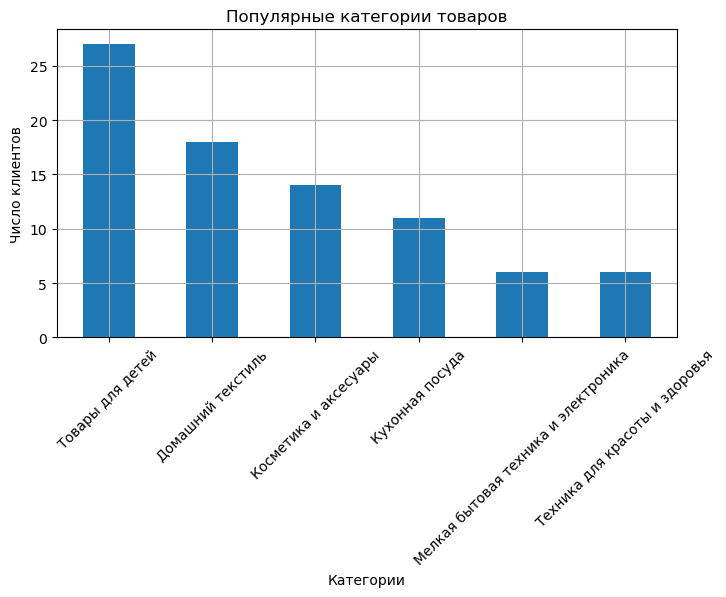

In [93]:
display(data_segment['популярная_категория'].value_counts())
data_segment['популярная_категория'].value_counts().plot(kind='bar', \
                                                             title = 'Популярные категории товаров',\
                                                             xlabel='Категории', \
                                                             ylabel='Число клиентов', figsize = (8, 4),\
                                                        grid = True, rot=45);

Самые популярные категории товаров у этого сегмента покупателей - это "Товары для детей", "Домашний текстиль", "Косметика и аксессуары".
Для удержания активности этих клиентов на прежнем уровне имеет смысл оформить для них акции или предложить новинки по этим категориям товаров.

## Шаг 9. Общий вывод

***1)*** Перед выполнением основной задачи мы обработали данные в таблицах market_file (Основная информация о клиентах), money_file (выручка клиентов), money_time (время, проведенное клиентами на сайте) и money (прибыльность). Объединили данные из первых трех таблиц в одну.

***2)*** Провели исследовательский и корреляционный анализ данных. Мультиколлинеарности между признаками не выявлено, максимальная корреляция с целевым признаком у показателей числа просмотренных за визит страниц (75%) и времени, проведенного на сайте (69%).

***3)*** Для поиска лучшей модели мы задавали следующие гиперпарамтеры:
 - метод масштабирования StandardScaler(), RobustScaler() и MinMaxScaler();
 - модели DecisionTreeClassifier(), SVС(), KNeighborsClassifier() и LogisticRegression().
 
Для автоматического подбора гиперпараметров использовали инструменты RandomizedSearch и GridSearchCV.

Для этой задачи использовали метрику recall, потому что здесь было важно не пропустить тех клиентов, у которых снизилась активность (метка класса 1), минимизировав ошибки 2 рода. 

По итогам подбора GridSearch получили лучшую модель SVC  полиномиальным ядром степени 5, лучший скейлер StandardScaler и метрику Recall для лучшей модели 76%. На тестовой выборке модель показала более высокий Recall - 84,55%. Т е модель не пропускает 84,55% клиентов, которые в ближайшее время покажут снижение активности.

Использовали результаты GridSearch (модель SVC), т к это более точный инструмент, перебирающий все возможные значения, и показавший более высокий, чем RandomizedSearch, Recall на тестовой выборке. 

***4)*** По итогам анализа важности признаков методом SHAP выявили, что максимальное влияние на целевой признак оказывают факторы "страниц за визит", "минуты текущий месяц", "акционые покупки" и "число просмотренных категорий".

***5)*** Для выделения сегмента мы использовали и анализировали признак, максимально влияющий на целевой - "число просмотренных страниц за визит" и выявили, что  высокая вероятность снижения активности (выше 0.6) наблюдается у клиентов с числом просмотренных страниц менее 8. 

Для удержания покупательской активности выделенного сегмента покупателей рекомендуется оформить для них акции или предложить новинки по самым полярным для этого сегмента категориям товаров.
